# GEO datafinder

This notebook will document the progress in automating the gathering of GEO data for the WormExp database. The basic idea is to automate the search for gathering new data. More precisely, the idea would be to write a script that frequently skims GEO datasets for matches with transcriptomics and C.elegans conditions and will send an email or notification to me (or other person of choice) for review. A manual revision can then decide if the dataset will be included in the WormExp. Since the database is fed not only with GEO data but also for E-MEXP and other databases, the script should skim all available databases (or construct a script for every database). It remains to be seen which strategy is best. Additionally, with the GEO ID, information like the paper, references, etc. should be send, too.
Ideally, the revision procedure is streamlined as the script will give proposals for the category. 


Steps:
- Construct a script that finds GEO IDs belonging to C.elegans and transcriptomics data
    - at least the script should find all already existing GEO IDs
    - at best: find a query that finds the most datasets/papers
- If the script is working, connect it to an automated system/notification script
- Connect the script to skim various other databases


In [1]:
from Bio import Entrez
import GEOparse
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
pl.rcParams['figure.figsize'] = (14, 10)
pl.rcParams['ytick.labelsize'] = 12
pl.rcParams['xtick.labelsize'] = 11
pl.rcParams['axes.labelsize'] = 23
pl.rcParams['legend.fontsize'] = 20
sns.set_style('ticks')
c1, c2, c3, c4 = sns.color_palette("Set1", 4)

## Playing around with biopython and GEOparse

In [2]:
# Setup
Entrez.email = "jennifer.neumaier@ut.ee"
# Query
# Query configurations: https://www.ncbi.nlm.nih.gov/geo/info/qqtutorial.html 
query = "Caenorhabditis elegans [Organism] AND (Expression profiling by high throughput sequencing [DataSet Type] OR Expression profiling by array [DataSet Type]) AND 2015/01:2021/10[Publication Date]"

# Search, using history results if cached before
handle = Entrez.esearch(db='gds', term=query, retmax=5000, usehistory=True)
result = Entrez.read(handle)
handle.close()

# search for GSE numbers
uid_regex = re.compile('[1-9]+0+([1-9]+[0-9]*)')
exception_list = []
gse_bio = []
for uid in result["IdList"]:
    if re.search(uid_regex, uid):
        gse_bio.append('GSE' + uid_regex.match(uid).group(1))
    else:
        exception_list.append(uid)
    
#results = open("gse_bio.txt","w")
#for i in gse_bio:
#    results.write(i + "\n")
#results.close()

# store in pandas dataframe
gse_bio = pd.DataFrame(gse_bio, columns = ["GSE_output"])
gse_bio.head()
gse_bio.shape


(677, 1)

As can be seen in the cell above, biopython produces easily a long list of GSE IDs, here the query that was used was:
"Caenorhabditis elegans [Organism] AND Expression profiling by high throughput sequencing [DataSet Type]". 
This query can be improved if necessary. The next section will compare collected GSE IDs to already existing GSE IDs in the WormExp to get a feel of the quality of the query. It is to note that the -retmax value was set to 1500, but only 594 entries have been found. Therefore, the query has to be adapted to include more entries or "this is simply all".
In this part, the WormExp database will be characterized to find specific keywords or data types to update the query.

In [3]:
columns = ["Categories","Gene_Set_name","Refs","Data_From","number","Rawdata","Additional"]
WormExp = pd.read_csv('WormExp_geo.csv', encoding='ISO-8859-1', skipinitialspace=True, usecols=columns)
WormExp.head()

#results = open("gse_worm.txt","w")
#for i in WormExp.Rawdata:
#    results.write(i + "\n")
#results.close()

,Categories,Gene_Set_name,Refs,Data_From,number,Rawdata,Additional
0,Other,SL2-Enriched,http://www.ncbi.nlm.nih.gov/pubmed/12075352,Supplementary Table 2,756,GPE2975,NaN
1,Other,Operons1,http://www.ncbi.nlm.nih.gov/pubmed/12075352,Supplementary Table 2,765,GPE2975,NaN
2,Chemicals/stress,Down in Heat-Shocked,http://www.ncbi.nlm.nih.gov/pubmed/19533680,Table 2,12,GSE10787,NaN
3,Other,Changed microwave exposure,http://www.ncbi.nlm.nih.gov/pubmed/19533680,Table 1,28,GSE10787,NaN
4,Chemicals/stress,UP heat-shocked,http://www.ncbi.nlm.nih.gov/pubmed/19533680,Table 2,31,GSE10787,NaN


In [4]:
# Downloading more information about GSE datasets already existing in the database and saving it in extra .csv file.
gse_worm = pd.DataFrame(list(set(WormExp["Rawdata"])), columns = ["GSE_output"])
gse_worm["GSE_output"] = gse_worm.GSE_output.str.replace(' ' , '')

uid_regex = re.compile('[1-9]+0+([1-9]+[0-9]*)')
exception_list = []
df_final = pd.DataFrame()
for g in gse_worm["GSE_output"]:
    if re.search(uid_regex, g):
        gse = GEOparse.get_GEO(geo=g, destdir="./GSE_database")
        df = pd.DataFrame.from_dict([gse.metadata], orient = "columns")
        df_final = pd.concat([df_final,df], ignore_index = True)
    else:
        exception_list.append(g)

df_final.to_csv("GSE_database_analysis.csv")

29-Oct-2021 15:14:36 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:14:37 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:14:37 INFO GEOparse - Parsing ./GSE_database\GSE52102_family.soft.gz: 
29-Oct-2021 15:14:37 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:14:37 DEBUG GEOparse - SERIES: GSE52102
29-Oct-2021 15:14:37 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259379
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259380
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259381
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259382
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259383
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259384
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259385
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259386
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259387
29-Oct-2021 15:14:37 DEBUG GEOparse - SAMPLE: GSM1259388
29-Oct-2021

29-Oct-2021 15:15:08 DEBUG GEOparse - SAMPLE: GSM524972
29-Oct-2021 15:15:08 DEBUG GEOparse - SAMPLE: GSM524973
29-Oct-2021 15:15:08 DEBUG GEOparse - SAMPLE: GSM524974
29-Oct-2021 15:15:08 DEBUG GEOparse - SAMPLE: GSM524975
29-Oct-2021 15:15:08 DEBUG GEOparse - SAMPLE: GSM524976
29-Oct-2021 15:15:08 DEBUG GEOparse - SAMPLE: GSM524977
29-Oct-2021 15:15:08 DEBUG GEOparse - SAMPLE: GSM524978
29-Oct-2021 15:15:09 DEBUG GEOparse - SAMPLE: GSM524979
29-Oct-2021 15:15:09 DEBUG GEOparse - SAMPLE: GSM524980
29-Oct-2021 15:15:09 DEBUG GEOparse - SAMPLE: GSM524981
29-Oct-2021 15:15:09 DEBUG GEOparse - SAMPLE: GSM524982
29-Oct-2021 15:15:09 DEBUG GEOparse - SAMPLE: GSM524983
29-Oct-2021 15:15:09 DEBUG GEOparse - SAMPLE: GSM524984
29-Oct-2021 15:15:09 DEBUG GEOparse - SAMPLE: GSM524985
29-Oct-2021 15:15:09 DEBUG GEOparse - SAMPLE: GSM524986
29-Oct-2021 15:15:09 DEBUG GEOparse - SAMPLE: GSM524987
29-Oct-2021 15:15:10 DEBUG GEOparse - SAMPLE: GSM524988
29-Oct-2021 15:15:10 DEBUG GEOparse - SAMPLE: GS

29-Oct-2021 15:18:07 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:18:07 DEBUG GEOparse - SERIES: GSE3089
29-Oct-2021 15:18:07 DEBUG GEOparse - PLATFORM: GPL2653
29-Oct-2021 15:18:07 DEBUG GEOparse - SAMPLE: GSM68696
29-Oct-2021 15:18:07 DEBUG GEOparse - SAMPLE: GSM68697
29-Oct-2021 15:18:08 DEBUG GEOparse - SAMPLE: GSM68698
29-Oct-2021 15:18:08 DEBUG GEOparse - SAMPLE: GSM68699
29-Oct-2021 15:18:09 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:18:09 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:18:09 INFO GEOparse - Parsing ./GSE_database\GSE60420_family.soft.gz: 
29-Oct-2021 15:18:09 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:18:09 DEBUG GEOparse - SERIES: GSE60420
29-Oct-2021 15:18:09 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:18:09 DEBUG GEOparse - SAMPLE: GSM1479384
29-Oct-2021 15:18:09 DEBUG GEOparse - SAMPLE: GSM1479385
29-Oct-2021 15:18:09 DEBUG GEOparse - SAMPLE: GSM1479386
29-Oct-2021 15:18:09 DE

29-Oct-2021 15:18:11 DEBUG GEOparse - SAMPLE: GSM760614
29-Oct-2021 15:18:11 DEBUG GEOparse - SAMPLE: GSM760615
29-Oct-2021 15:18:11 DEBUG GEOparse - SAMPLE: GSM760616
29-Oct-2021 15:18:11 DEBUG GEOparse - SAMPLE: GSM760617
29-Oct-2021 15:18:11 DEBUG GEOparse - SAMPLE: GSM760618
29-Oct-2021 15:18:11 DEBUG GEOparse - SAMPLE: GSM760619
29-Oct-2021 15:18:12 DEBUG GEOparse - SAMPLE: GSM760620
29-Oct-2021 15:18:12 DEBUG GEOparse - SAMPLE: GSM760621
29-Oct-2021 15:18:12 DEBUG GEOparse - SAMPLE: GSM760622
29-Oct-2021 15:18:12 DEBUG GEOparse - SAMPLE: GSM760623
29-Oct-2021 15:18:12 DEBUG GEOparse - SAMPLE: GSM760624
29-Oct-2021 15:18:12 DEBUG GEOparse - SAMPLE: GSM760625
29-Oct-2021 15:18:12 DEBUG GEOparse - SAMPLE: GSM760626
29-Oct-2021 15:18:12 DEBUG GEOparse - SAMPLE: GSM760627
29-Oct-2021 15:18:12 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:18:12 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:18:12 INFO GEOparse - Parsing ./GSE_d

29-Oct-2021 15:18:30 DEBUG GEOparse - SAMPLE: GSM840602
29-Oct-2021 15:18:30 DEBUG GEOparse - SAMPLE: GSM840603
29-Oct-2021 15:18:30 DEBUG GEOparse - SAMPLE: GSM840604
29-Oct-2021 15:18:30 DEBUG GEOparse - SAMPLE: GSM840605
29-Oct-2021 15:18:30 DEBUG GEOparse - SAMPLE: GSM840606
29-Oct-2021 15:18:30 DEBUG GEOparse - SAMPLE: GSM840607
29-Oct-2021 15:18:30 DEBUG GEOparse - SAMPLE: GSM840608
29-Oct-2021 15:18:31 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:18:31 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:18:31 INFO GEOparse - Parsing ./GSE_database\GSE16050_family.soft.gz: 
29-Oct-2021 15:18:31 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:18:31 DEBUG GEOparse - SERIES: GSE16050
29-Oct-2021 15:18:31 DEBUG GEOparse - PLATFORM: GPL200
29-Oct-2021 15:18:31 DEBUG GEOparse - SAMPLE: GSM401793
29-Oct-2021 15:18:32 DEBUG GEOparse - SAMPLE: GSM401794
29-Oct-2021 15:18:32 DEBUG GEOparse - SAMPLE: GSM401795
29-Oct-2021 15:18:32 DE

29-Oct-2021 15:18:43 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:18:43 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:18:43 INFO GEOparse - Parsing ./GSE_database\GSE30977_family.soft.gz: 
29-Oct-2021 15:18:43 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:18:43 DEBUG GEOparse - SERIES: GSE30977
29-Oct-2021 15:18:43 DEBUG GEOparse - PLATFORM: GPL10094
29-Oct-2021 15:18:44 DEBUG GEOparse - SAMPLE: GSM767758
29-Oct-2021 15:18:44 DEBUG GEOparse - SAMPLE: GSM767759
29-Oct-2021 15:18:45 DEBUG GEOparse - SAMPLE: GSM767760
29-Oct-2021 15:18:45 DEBUG GEOparse - SAMPLE: GSM767761
29-Oct-2021 15:18:45 DEBUG GEOparse - SAMPLE: GSM767762
29-Oct-2021 15:18:45 DEBUG GEOparse - SAMPLE: GSM767763
29-Oct-2021 15:18:45 DEBUG GEOparse - SAMPLE: GSM767764
29-Oct-2021 15:18:46 DEBUG GEOparse - SAMPLE: GSM767765
29-Oct-2021 15:18:46 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:18:46 INFO GEOparse - File alrea

29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221096
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221097
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221098
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221099
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221100
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221101
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221102
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221103
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221104
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221105
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221106
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221107
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221108
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221109
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221110
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221111
29-Oct-2021 15:18:52 DEBUG GEOparse - SAMPLE: GSM1221112
29-Oct-2021 15:18:52 DEBUG GEOp

29-Oct-2021 15:18:57 DEBUG GEOparse - SAMPLE: GSM407027
29-Oct-2021 15:18:57 DEBUG GEOparse - SAMPLE: GSM407028
29-Oct-2021 15:18:57 DEBUG GEOparse - SAMPLE: GSM407029
29-Oct-2021 15:18:57 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:18:57 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:18:57 INFO GEOparse - Parsing ./GSE_database\GSE52064_family.soft.gz: 
29-Oct-2021 15:18:57 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:18:57 DEBUG GEOparse - SERIES: GSE52064
29-Oct-2021 15:18:57 DEBUG GEOparse - PLATFORM: GPL200
29-Oct-2021 15:18:58 DEBUG GEOparse - SAMPLE: GSM1258141
29-Oct-2021 15:18:58 DEBUG GEOparse - SAMPLE: GSM1258142
29-Oct-2021 15:18:58 DEBUG GEOparse - SAMPLE: GSM1258143
29-Oct-2021 15:18:58 DEBUG GEOparse - SAMPLE: GSM1258144
29-Oct-2021 15:18:58 DEBUG GEOparse - SAMPLE: GSM1258145
29-Oct-2021 15:18:58 DEBUG GEOparse - SAMPLE: GSM1258146
29-Oct-2021 15:18:58 DEBUG GEOparse - SAMPLE: GSM1258147
29-Oct-2021 15:1

29-Oct-2021 15:20:33 DEBUG GEOparse - SAMPLE: GSM761569
29-Oct-2021 15:20:34 DEBUG GEOparse - SAMPLE: GSM761570
29-Oct-2021 15:20:34 DEBUG GEOparse - SAMPLE: GSM761571
29-Oct-2021 15:20:34 DEBUG GEOparse - SAMPLE: GSM761572
29-Oct-2021 15:20:35 DEBUG GEOparse - SAMPLE: GSM761573
29-Oct-2021 15:20:35 DEBUG GEOparse - SAMPLE: GSM761574
29-Oct-2021 15:20:35 DEBUG GEOparse - SAMPLE: GSM761575
29-Oct-2021 15:20:35 DEBUG GEOparse - SAMPLE: GSM761576
29-Oct-2021 15:20:36 DEBUG GEOparse - SAMPLE: GSM761577
29-Oct-2021 15:20:36 DEBUG GEOparse - SAMPLE: GSM761578
29-Oct-2021 15:20:36 DEBUG GEOparse - SAMPLE: GSM761579
29-Oct-2021 15:20:36 DEBUG GEOparse - SAMPLE: GSM761580
29-Oct-2021 15:20:37 DEBUG GEOparse - SAMPLE: GSM761581
29-Oct-2021 15:20:37 DEBUG GEOparse - SAMPLE: GSM761582
29-Oct-2021 15:20:37 DEBUG GEOparse - SAMPLE: GSM761583
29-Oct-2021 15:20:38 DEBUG GEOparse - SAMPLE: GSM761584
29-Oct-2021 15:20:38 DEBUG GEOparse - SAMPLE: GSM761585
29-Oct-2021 15:20:38 DEBUG GEOparse - SAMPLE: GS

29-Oct-2021 15:20:49 DEBUG GEOparse - SAMPLE: GSM91451
29-Oct-2021 15:20:50 DEBUG GEOparse - SAMPLE: GSM91452
29-Oct-2021 15:20:50 DEBUG GEOparse - SAMPLE: GSM91453
29-Oct-2021 15:20:50 DEBUG GEOparse - SAMPLE: GSM91454
29-Oct-2021 15:20:51 DEBUG GEOparse - SAMPLE: GSM91455
29-Oct-2021 15:20:51 DEBUG GEOparse - SAMPLE: GSM91456
29-Oct-2021 15:20:52 DEBUG GEOparse - SAMPLE: GSM91457
29-Oct-2021 15:20:52 DEBUG GEOparse - SAMPLE: GSM91458
29-Oct-2021 15:20:52 DEBUG GEOparse - SAMPLE: GSM91459
29-Oct-2021 15:20:53 DEBUG GEOparse - SAMPLE: GSM91460
29-Oct-2021 15:20:53 DEBUG GEOparse - SAMPLE: GSM91461
29-Oct-2021 15:20:53 DEBUG GEOparse - SAMPLE: GSM91462
29-Oct-2021 15:20:54 DEBUG GEOparse - SAMPLE: GSM91463
29-Oct-2021 15:20:54 DEBUG GEOparse - SAMPLE: GSM91464
29-Oct-2021 15:20:55 DEBUG GEOparse - SAMPLE: GSM91465
29-Oct-2021 15:20:55 DEBUG GEOparse - SAMPLE: GSM91466
29-Oct-2021 15:20:55 DEBUG GEOparse - SAMPLE: GSM91467
29-Oct-2021 15:20:56 DEBUG GEOparse - SAMPLE: GSM91468
29-Oct-202

29-Oct-2021 15:21:05 DEBUG GEOparse - SAMPLE: GSM1220541
29-Oct-2021 15:21:05 DEBUG GEOparse - SAMPLE: GSM1220542
29-Oct-2021 15:21:05 DEBUG GEOparse - SAMPLE: GSM1220543
29-Oct-2021 15:21:05 DEBUG GEOparse - SAMPLE: GSM1220544
29-Oct-2021 15:21:05 DEBUG GEOparse - SAMPLE: GSM1220545
29-Oct-2021 15:21:05 DEBUG GEOparse - SAMPLE: GSM1220546
29-Oct-2021 15:21:06 DEBUG GEOparse - SAMPLE: GSM1220547
29-Oct-2021 15:21:06 DEBUG GEOparse - SAMPLE: GSM1220548
29-Oct-2021 15:21:06 DEBUG GEOparse - SAMPLE: GSM1220549
29-Oct-2021 15:21:06 DEBUG GEOparse - SAMPLE: GSM1220550
29-Oct-2021 15:21:06 DEBUG GEOparse - SAMPLE: GSM1220551
29-Oct-2021 15:21:06 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:21:06 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:21:06 INFO GEOparse - Parsing ./GSE_database\GSE43207_family.soft.gz: 
29-Oct-2021 15:21:06 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:21:06 DEBUG GEOparse - SERIES: GSE43207
29-Oct-2021

29-Oct-2021 15:21:21 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:21:21 DEBUG GEOparse - SERIES: GSE4402
29-Oct-2021 15:21:21 DEBUG GEOparse - PLATFORM: GPL3390
29-Oct-2021 15:21:21 DEBUG GEOparse - PLATFORM: GPL3391
29-Oct-2021 15:21:21 DEBUG GEOparse - SAMPLE: GSM93684
29-Oct-2021 15:21:21 DEBUG GEOparse - SAMPLE: GSM93685
29-Oct-2021 15:21:22 DEBUG GEOparse - SAMPLE: GSM93686
29-Oct-2021 15:21:22 DEBUG GEOparse - SAMPLE: GSM93687
29-Oct-2021 15:21:22 DEBUG GEOparse - SAMPLE: GSM93688
29-Oct-2021 15:21:23 DEBUG GEOparse - SAMPLE: GSM93689
29-Oct-2021 15:21:23 DEBUG GEOparse - SAMPLE: GSM93690
29-Oct-2021 15:21:23 DEBUG GEOparse - SAMPLE: GSM93691
29-Oct-2021 15:21:24 DEBUG GEOparse - SAMPLE: GSM93692
29-Oct-2021 15:21:24 DEBUG GEOparse - SAMPLE: GSM93693
29-Oct-2021 15:21:25 DEBUG GEOparse - SAMPLE: GSM93694
29-Oct-2021 15:21:25 DEBUG GEOparse - SAMPLE: GSM93695
29-Oct-2021 15:21:25 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:21:25 INFO GEOpa

29-Oct-2021 15:23:02 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:23:02 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:23:02 INFO GEOparse - Parsing ./GSE_database\GSE23013_family.soft.gz: 
29-Oct-2021 15:23:02 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:23:02 DEBUG GEOparse - SERIES: GSE23013
29-Oct-2021 15:23:02 DEBUG GEOparse - PLATFORM: GPL200
29-Oct-2021 15:23:03 DEBUG GEOparse - SAMPLE: GSM567790
29-Oct-2021 15:23:03 DEBUG GEOparse - SAMPLE: GSM567791
29-Oct-2021 15:23:03 DEBUG GEOparse - SAMPLE: GSM567792
29-Oct-2021 15:23:04 DEBUG GEOparse - SAMPLE: GSM567793
29-Oct-2021 15:23:04 DEBUG GEOparse - SAMPLE: GSM567794
29-Oct-2021 15:23:04 DEBUG utils - Directory ./GSE_database already exists. Skipping.
29-Oct-2021 15:23:04 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:23:04 INFO GEOparse - Parsing ./GSE_database\GSE8004_family.soft.gz: 
29-Oct-2021 15:23:04 DEBUG GEOparse - DATABASE: GeoMia

29-Oct-2021 15:23:26 DEBUG GEOparse - SAMPLE: GSM11118
29-Oct-2021 15:23:26 DEBUG GEOparse - SAMPLE: GSM11119
29-Oct-2021 15:23:26 DEBUG GEOparse - SAMPLE: GSM11120
29-Oct-2021 15:23:26 DEBUG GEOparse - SAMPLE: GSM11121
29-Oct-2021 15:23:26 DEBUG GEOparse - SAMPLE: GSM11122
29-Oct-2021 15:23:27 DEBUG GEOparse - SAMPLE: GSM11123
29-Oct-2021 15:23:27 DEBUG GEOparse - SAMPLE: GSM11124
29-Oct-2021 15:23:27 DEBUG GEOparse - SAMPLE: GSM11125
29-Oct-2021 15:23:27 DEBUG GEOparse - SAMPLE: GSM11126
29-Oct-2021 15:23:27 DEBUG GEOparse - SAMPLE: GSM11127
29-Oct-2021 15:23:28 DEBUG GEOparse - SAMPLE: GSM113611
29-Oct-2021 15:23:28 DEBUG GEOparse - SAMPLE: GSM113612
29-Oct-2021 15:23:28 DEBUG GEOparse - SAMPLE: GSM113613
29-Oct-2021 15:23:28 DEBUG GEOparse - SAMPLE: GSM113614
29-Oct-2021 15:23:29 DEBUG GEOparse - SAMPLE: GSM113664
29-Oct-2021 15:23:29 DEBUG GEOparse - SAMPLE: GSM113665
29-Oct-2021 15:23:29 DEBUG GEOparse - SAMPLE: GSM113666
29-Oct-2021 15:23:29 DEBUG GEOparse - SAMPLE: GSM113724
29

List of GSE results have been extracted from both biopython query and from the already existing WormExp. In the next section both lists will be compared and a dataframe will be formed to see directly which GSE IDs appear in both tables and which do not. The result here has been produces with R but for a functional pipeline, this has to be added aswell

In [5]:
# Put Rawdata in an extra table so that pd.merge can use it
gse_worm = pd.DataFrame(list(set(WormExp["Rawdata"])), columns = ["GSE_output"])
gse_worm["GSE_output"] = gse_worm.GSE_output.str.replace(' ' , '')

# Use pd.merge to create a table that contains all GSEs but with indicators where they are found
# left_only = already in database
# right_only = found on ncbi
output = pd.merge(gse_worm, gse_bio, how='outer', indicator= True)

both = np.where(output == "both")[0]
left = np.where(output == "left_only")[0]
right = np.where(output == "right_only")[0]

# Save output in extra file
output.to_csv("output.csv")

print(f"Number of entries found with query: {len(right)}")
print(f"Number of entries found in database: {len(left)}")
print(f"Number of found queries already in database: {len(both)}") 

Number of entries found with query: 656
Number of entries found in database: 262
Number of found queries already in database: 21


The number of merged GSE keys is 174 entries, whereas biopython produces 602 entries and the WormExp already contains 1441.
Furthermore, the highest GSE in gse_worm is ~68000. However, biopython produces GSE in ~100000.
For further steps, the following has to be checked:
- what kind of data are the missing GSEs that are already from WormExp -> can the query be updated?
- Is all data from 68000 - 100000 new data or has most of it been excluded because it is not the type of data the database wants?

After updating the query to include also experiments still conducted by arrays as well as all publications after 2015/01, the number of entries found with the query were 640. A few more, than before, probably the included array experiments (all newer experiments use high sequencing throughput as tag). GSE results found with query now start at roughly 62000 and end at 100000, which fits the estimations to start searching with the newest GSE numbers. 
Since only 95 entries were found in both databases, which after a closer look are the overlapping ones in 2015. 

When searching for datasets in from 2005 to 2015, an overlap of 1317 entries can be found, with only 237 new ones. 
This supports the next steps: create new data table with all datasets starting at 2015 (without overlaps) and 
start categorizing there.

Starting at publication date 2015, 665 entries can be found. 262 are already in the database and 21 are overlapping.

In [6]:
# save information from output list "left_only" gse objects in a table, for better comparison further on
# a second table and third table will be created for better comparison. Further work will be conducted in Excel.

geo = output["GSE_output"].loc[(np.where(output == "right_only"))[0]]

df_final = pd.DataFrame()
for g in geo:
    gse = GEOparse.get_GEO(geo=g, destdir="./GSE_query")
    df = pd.DataFrame.from_dict([gse.metadata], orient = "columns")
    df_final = pd.concat([df_final,df], ignore_index = True)

df_final.to_csv("GSE_query_results_new.csv")

29-Oct-2021 15:25:46 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:25:46 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE158nnn/GSE158274/soft/GSE158274_family.soft.gz to ./GSE_query\GSE158274_family.soft.gz
100%|█████████████████████████████████████████████████████████████████████████████| 8.27k/8.27k [00:00<00:00, 12.5kB/s]
29-Oct-2021 15:25:48 DEBUG downloader - Size validation passed
29-Oct-2021 15:25:48 DEBUG downloader - Moving C:\Users\jenni\AppData\Local\Temp\tmpswn5qmel to D:\Bioinformatics\Projects\WormExp\datafinder\GSE_query\GSE158274_family.soft.gz
29-Oct-2021 15:25:48 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE158nnn/GSE158274/soft/GSE158274_family.soft.gz
29-Oct-2021 15:25:48 INFO GEOparse - Parsing ./GSE_query\GSE158274_family.soft.gz: 
29-Oct-2021 15:25:48 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:25:48 DEBUG GEOparse - SERIES: GSE158274
29-Oct-2021 15:25:48 DEBUG GEOp

29-Oct-2021 15:25:54 DEBUG GEOparse - SAMPLE: GSM3017720
29-Oct-2021 15:25:54 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:25:54 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110844/soft/GSE110844_family.soft.gz to ./GSE_query\GSE110844_family.soft.gz
100%|█████████████████████████████████████████████████████████████████████████████| 1.76k/1.76k [00:00<00:00, 2.85kB/s]
29-Oct-2021 15:25:55 DEBUG downloader - Size validation passed
29-Oct-2021 15:25:55 DEBUG downloader - Moving C:\Users\jenni\AppData\Local\Temp\tmpswygb_pz to D:\Bioinformatics\Projects\WormExp\datafinder\GSE_query\GSE110844_family.soft.gz
29-Oct-2021 15:25:55 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110844/soft/GSE110844_family.soft.gz
29-Oct-2021 15:25:55 INFO GEOparse - Parsing ./GSE_query\GSE110844_family.soft.gz: 
29-Oct-2021 15:25:55 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:25:55 DEBUG GEO

29-Oct-2021 15:26:04 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110839/soft/GSE110839_family.soft.gz
29-Oct-2021 15:26:04 INFO GEOparse - Parsing ./GSE_query\GSE110839_family.soft.gz: 
29-Oct-2021 15:26:04 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:04 DEBUG GEOparse - SERIES: GSE110839
29-Oct-2021 15:26:04 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:26:04 DEBUG GEOparse - SAMPLE: GSM3017663
29-Oct-2021 15:26:04 DEBUG GEOparse - SAMPLE: GSM3017664
29-Oct-2021 15:26:04 DEBUG GEOparse - SAMPLE: GSM3017665
29-Oct-2021 15:26:04 DEBUG GEOparse - SAMPLE: GSM3017666
29-Oct-2021 15:26:04 DEBUG GEOparse - SAMPLE: GSM3017667
29-Oct-2021 15:26:04 DEBUG GEOparse - SAMPLE: GSM3017668
29-Oct-2021 15:26:04 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:04 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110838/soft/GSE110838_family.soft.gz to ./GSE_query\GSE110838_family.

100%|█████████████████████████████████████████████████████████████████████████████| 2.71k/2.71k [00:00<00:00, 4.25kB/s]
29-Oct-2021 15:26:11 DEBUG downloader - Size validation passed
29-Oct-2021 15:26:11 DEBUG downloader - Moving C:\Users\jenni\AppData\Local\Temp\tmp6n7kao2d to D:\Bioinformatics\Projects\WormExp\datafinder\GSE_query\GSE110835_family.soft.gz
29-Oct-2021 15:26:11 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110835/soft/GSE110835_family.soft.gz
29-Oct-2021 15:26:11 INFO GEOparse - Parsing ./GSE_query\GSE110835_family.soft.gz: 
29-Oct-2021 15:26:11 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:11 DEBUG GEOparse - SERIES: GSE110835
29-Oct-2021 15:26:11 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:26:11 DEBUG GEOparse - SAMPLE: GSM3017570
29-Oct-2021 15:26:11 DEBUG GEOparse - SAMPLE: GSM3017571
29-Oct-2021 15:26:11 DEBUG GEOparse - SAMPLE: GSM3017572
29-Oct-2021 15:26:11 DEBUG GEOparse - SAMPLE: GSM3017573
29-Oct

29-Oct-2021 15:26:15 DEBUG GEOparse - SERIES: GSE175950
29-Oct-2021 15:26:15 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351767
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351768
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351769
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351770
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351771
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351772
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351773
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351774
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351775
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351776
29-Oct-2021 15:26:15 DEBUG GEOparse - SAMPLE: GSM5351777
29-Oct-2021 15:26:15 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:15 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:15 INFO GEOparse - Parsing ./GSE_query\GSE181115_family.soft.gz: 
29-Oct-2021 15:

29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208696
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208697
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208698
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208699
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208700
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208701
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208702
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208703
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208704
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208705
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208706
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208707
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208708
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208709
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208710
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208711
29-Oct-2021 15:26:17 DEBUG GEOparse - SAMPLE: GSM5208712
29-Oct-2021 15:26:17 DEBUG GEOp

29-Oct-2021 15:26:21 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:21 INFO GEOparse - Parsing ./GSE_query\GSE183331_family.soft.gz: 
29-Oct-2021 15:26:21 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:21 DEBUG GEOparse - SERIES: GSE183331
29-Oct-2021 15:26:21 DEBUG GEOparse - PLATFORM: GPL19757
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555705
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555706
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555707
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555708
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555709
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555710
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555711
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555712
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555713
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555714
29-Oct-2021 15:26:21 DEBUG GEOparse - SAMPLE: GSM5555715
29-Oct-2021 15:26:21 DEBUG GEOparse - SAM

29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5284053
29-Oct-2021 15:26:23 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:23 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:23 INFO GEOparse - Parsing ./GSE_query\GSE164775_family.soft.gz: 
29-Oct-2021 15:26:23 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:23 DEBUG GEOparse - SERIES: GSE164775
29-Oct-2021 15:26:23 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5018551
29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5018552
29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5018553
29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5018554
29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5018555
29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5018556
29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5018557
29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5018558
29-Oct-2021 15:26:23 DEBUG GEOparse - SAMPLE: GSM5018559
29-Oct-2021 15:

29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172430
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172431
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172432
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172433
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172434
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172435
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172436
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172437
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172438
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172439
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172440
29-Oct-2021 15:26:24 DEBUG GEOparse - SAMPLE: GSM5172441
29-Oct-2021 15:26:24 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:24 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:24 INFO GEOparse - Parsing ./GSE_query\GSE168924_family.soft.gz: 
29-Oct-2021 15:26:24 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15

29-Oct-2021 15:26:25 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:25 INFO GEOparse - Parsing ./GSE_query\GSE180506_family.soft.gz: 
29-Oct-2021 15:26:25 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:25 DEBUG GEOparse - SERIES: GSE180506
29-Oct-2021 15:26:25 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464062
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464063
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464064
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464065
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464066
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464067
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464068
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464069
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464070
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464071
29-Oct-2021 15:26:25 DEBUG GEOparse - SAMPLE: GSM5464072
29-Oct-2021 15:26:25 DEBUG GEOparse - SAM

29-Oct-2021 15:26:26 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:26 DEBUG GEOparse - SERIES: GSE149944
29-Oct-2021 15:26:26 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:26:26 DEBUG GEOparse - SAMPLE: GSM4518505
29-Oct-2021 15:26:26 DEBUG GEOparse - SAMPLE: GSM4518506
29-Oct-2021 15:26:26 DEBUG GEOparse - SAMPLE: GSM4518507
29-Oct-2021 15:26:26 DEBUG GEOparse - SAMPLE: GSM4518508
29-Oct-2021 15:26:26 DEBUG GEOparse - SAMPLE: GSM4518509
29-Oct-2021 15:26:26 DEBUG GEOparse - SAMPLE: GSM4518510
29-Oct-2021 15:26:26 DEBUG GEOparse - SAMPLE: GSM4518511
29-Oct-2021 15:26:26 DEBUG GEOparse - SAMPLE: GSM4518512
29-Oct-2021 15:26:26 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:26 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:26 INFO GEOparse - Parsing ./GSE_query\GSE162067_family.soft.gz: 
29-Oct-2021 15:26:26 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:26 DEBUG GEOparse - SERIES: GSE162067
29-Oct-2021 15:2

29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932584
29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932585
29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932586
29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932587
29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932588
29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932589
29-Oct-2021 15:26:27 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:27 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:27 INFO GEOparse - Parsing ./GSE_query\GSE162066_family.soft.gz: 
29-Oct-2021 15:26:27 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:27 DEBUG GEOparse - SERIES: GSE162066
29-Oct-2021 15:26:27 DEBUG GEOparse - PLATFORM: GPL26672
29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932546
29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932547
29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932548
29-Oct-2021 15:26:27 DEBUG GEOparse - SAMPLE: GSM4932549
29-Oct-2021 15:

29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932478
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932479
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932480
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932481
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932482
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932483
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932484
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932485
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932486
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932487
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932488
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932489
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932490
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932491
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932492
29-Oct-2021 15:26:29 DEBUG GEOparse - SAMPLE: GSM4932493
29-Oct-2021 15:26:29 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oc

29-Oct-2021 15:26:30 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:30 DEBUG GEOparse - SERIES: GSE176088
29-Oct-2021 15:26:30 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:26:30 DEBUG GEOparse - SAMPLE: GSM5354718
29-Oct-2021 15:26:30 DEBUG GEOparse - SAMPLE: GSM5354719
29-Oct-2021 15:26:30 DEBUG GEOparse - SAMPLE: GSM5354720
29-Oct-2021 15:26:30 DEBUG GEOparse - SAMPLE: GSM5354721
29-Oct-2021 15:26:30 DEBUG GEOparse - SAMPLE: GSM5354722
29-Oct-2021 15:26:30 DEBUG GEOparse - SAMPLE: GSM5354723
29-Oct-2021 15:26:30 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:30 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:30 INFO GEOparse - Parsing ./GSE_query\GSE151828_family.soft.gz: 
29-Oct-2021 15:26:30 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:30 DEBUG GEOparse - SERIES: GSE151828
29-Oct-2021 15:26:30 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:26:30 DEBUG GEOparse - PLATFORM: GPL19757
29-Oct-2021 15:2

29-Oct-2021 15:26:31 DEBUG GEOparse - SERIES: GSE172079
29-Oct-2021 15:26:31 DEBUG GEOparse - PLATFORM: GPL24892
29-Oct-2021 15:26:31 DEBUG GEOparse - SAMPLE: GSM5241437
29-Oct-2021 15:26:31 DEBUG GEOparse - SAMPLE: GSM5241438
29-Oct-2021 15:26:31 DEBUG GEOparse - SAMPLE: GSM5241439
29-Oct-2021 15:26:31 DEBUG GEOparse - SAMPLE: GSM5241440
29-Oct-2021 15:26:31 DEBUG GEOparse - SAMPLE: GSM5241441
29-Oct-2021 15:26:31 DEBUG GEOparse - SAMPLE: GSM5241442
29-Oct-2021 15:26:31 DEBUG GEOparse - SAMPLE: GSM5241443
29-Oct-2021 15:26:31 DEBUG GEOparse - SAMPLE: GSM5241444
29-Oct-2021 15:26:31 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:31 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:31 INFO GEOparse - Parsing ./GSE_query\GSE173987_family.soft.gz: 
29-Oct-2021 15:26:31 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:31 DEBUG GEOparse - SERIES: GSE173987
29-Oct-2021 15:26:31 DEBUG GEOparse - PLATFORM: GPL30091
29-Oct-2021 15:2

29-Oct-2021 15:26:32 INFO GEOparse - Parsing ./GSE_query\GSE171836_family.soft.gz: 
29-Oct-2021 15:26:32 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:32 DEBUG GEOparse - SERIES: GSE171836
29-Oct-2021 15:26:32 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:26:32 DEBUG GEOparse - SAMPLE: GSM5235564
29-Oct-2021 15:26:32 DEBUG GEOparse - SAMPLE: GSM5235565
29-Oct-2021 15:26:32 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:32 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:32 INFO GEOparse - Parsing ./GSE_query\GSE155935_family.soft.gz: 
29-Oct-2021 15:26:32 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:32 DEBUG GEOparse - SERIES: GSE155935
29-Oct-2021 15:26:32 DEBUG GEOparse - PLATFORM: GPL26672
29-Oct-2021 15:26:32 DEBUG GEOparse - SAMPLE: GSM4716525
29-Oct-2021 15:26:32 DEBUG GEOparse - SAMPLE: GSM4716526
29-Oct-2021 15:26:32 DEBUG GEOparse - SAMPLE: GSM4716527
29-Oct-2021 15:26:32 DEBUG GEOparse - SAMPLE: 

29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4408176
29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4408177
29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4408178
29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4408179
29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4408180
29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4408181
29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4408182
29-Oct-2021 15:26:33 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:33 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:33 INFO GEOparse - Parsing ./GSE_query\GSE155077_family.soft.gz: 
29-Oct-2021 15:26:33 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:33 DEBUG GEOparse - SERIES: GSE155077
29-Oct-2021 15:26:33 DEBUG GEOparse - PLATFORM: GPL19757
29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4694757
29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4694758
29-Oct-2021 15:26:33 DEBUG GEOparse - SAMPLE: GSM4694759
29-Oct-2021 15:

29-Oct-2021 15:26:34 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:34 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:34 INFO GEOparse - Parsing ./GSE_query\GSE151731_family.soft.gz: 
29-Oct-2021 15:26:34 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:34 DEBUG GEOparse - SERIES: GSE151731
29-Oct-2021 15:26:34 DEBUG GEOparse - PLATFORM: GPL26672
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589373
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589374
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589375
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589376
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589377
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589378
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589379
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589380
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589381
29-Oct-2021 15:26:34 DEBUG GEOparse - SAMPLE: GSM4589382
29-Oct-2021 15:

29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589041
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589042
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589043
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589044
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589045
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589046
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589047
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589048
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589049
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589050
29-Oct-2021 15:26:36 DEBUG GEOparse - SAMPLE: GSM4589051
29-Oct-2021 15:26:36 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:36 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:36 INFO GEOparse - Parsing ./GSE_query\GSE151714_family.soft.gz: 
29-Oct-2021 15:26:36 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:36 DEBUG GEOparse - SERIES: GSE151714
29-Oct-2021 15:

29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5232898
29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5232899
29-Oct-2021 15:26:37 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:37 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:37 INFO GEOparse - Parsing ./GSE_query\GSE171726_family.soft.gz: 
29-Oct-2021 15:26:37 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:37 DEBUG GEOparse - SERIES: GSE171726
29-Oct-2021 15:26:37 DEBUG GEOparse - PLATFORM: GPL19757
29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5231627
29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5231628
29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5231629
29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5231630
29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5231631
29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5231632
29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5231633
29-Oct-2021 15:26:37 DEBUG GEOparse - SAMPLE: GSM5231634
29-Oct-2021 15:

29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5206723
29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5206724
29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5206725
29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5206726
29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5206727
29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5206728
29-Oct-2021 15:26:38 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:38 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:38 INFO GEOparse - Parsing ./GSE_query\GSE169204_family.soft.gz: 
29-Oct-2021 15:26:38 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:38 DEBUG GEOparse - SERIES: GSE169204
29-Oct-2021 15:26:38 DEBUG GEOparse - PLATFORM: GPL25145
29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5183489
29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5183490
29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5183491
29-Oct-2021 15:26:38 DEBUG GEOparse - SAMPLE: GSM5183492
29-Oct-2021 15:

29-Oct-2021 15:26:41 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:26:41 DEBUG GEOparse - SAMPLE: GSM4610383
29-Oct-2021 15:26:41 DEBUG GEOparse - SAMPLE: GSM4610384
29-Oct-2021 15:26:41 DEBUG GEOparse - SAMPLE: GSM4610385
29-Oct-2021 15:26:41 DEBUG GEOparse - SAMPLE: GSM4610386
29-Oct-2021 15:26:41 DEBUG GEOparse - SAMPLE: GSM4610387
29-Oct-2021 15:26:41 DEBUG GEOparse - SAMPLE: GSM4610388
29-Oct-2021 15:26:41 DEBUG GEOparse - SAMPLE: GSM4610389
29-Oct-2021 15:26:41 DEBUG GEOparse - SAMPLE: GSM4610390
29-Oct-2021 15:26:41 DEBUG GEOparse - SAMPLE: GSM4610391
29-Oct-2021 15:26:42 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:26:42 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:26:42 INFO GEOparse - Parsing ./GSE_query\GSE137861_family.soft.gz: 
29-Oct-2021 15:26:42 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:26:42 DEBUG GEOparse - SERIES: GSE137861
29-Oct-2021 15:26:42 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:

29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016470
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016471
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016472
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016473
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016474
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016475
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016476
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016477
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016478
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016479
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016480
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016481
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016482
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016483
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016484
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016485
29-Oct-2021 15:26:43 DEBUG GEOparse - SAMPLE: GSM5016486
29-Oct-2021 15:26:43 DEBUG GEOp

29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363855
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363856
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363857
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363858
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363859
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363860
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363861
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363862
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363863
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363864
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363865
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363866
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363867
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363868
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4363869
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4818858
29-Oct-2021 15:26:44 DEBUG GEOparse - SAMPLE: GSM4818859
29-Oct-2021 15:26:44 DEBUG GEOp

29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524118
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524119
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524120
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524121
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524122
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524123
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524124
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524125
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524126
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524127
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524128
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524129
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524130
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524131
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524132
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524133
29-Oct-2021 15:26:47 DEBUG GEOparse - SAMPLE: GSM4524134
29-Oct-2021 15:26:47 DEBUG GEOp

29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978166
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978167
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978168
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978169
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978170
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978171
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978172
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978173
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978174
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978175
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978176
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978177
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978178
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978179
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978180
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978181
29-Oct-2021 15:26:48 DEBUG GEOparse - SAMPLE: GSM4978182
29-Oct-2021 15:26:49 DEBUG GEOp

29-Oct-2021 15:27:06 DEBUG GEOparse - SAMPLE: GSM4290817
29-Oct-2021 15:27:06 DEBUG GEOparse - SAMPLE: GSM4290818
29-Oct-2021 15:27:07 DEBUG GEOparse - SAMPLE: GSM4290819
29-Oct-2021 15:27:07 DEBUG GEOparse - SAMPLE: GSM4290820
29-Oct-2021 15:27:07 DEBUG GEOparse - SAMPLE: GSM4290821
29-Oct-2021 15:27:07 DEBUG GEOparse - SAMPLE: GSM4290822
29-Oct-2021 15:27:07 DEBUG GEOparse - SAMPLE: GSM4290823
29-Oct-2021 15:27:08 DEBUG GEOparse - SAMPLE: GSM4290824
29-Oct-2021 15:27:08 DEBUG GEOparse - SAMPLE: GSM4290825
29-Oct-2021 15:27:08 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:27:08 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:27:08 INFO GEOparse - Parsing ./GSE_query\GSE156318_family.soft.gz: 
29-Oct-2021 15:27:08 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:27:08 DEBUG GEOparse - SERIES: GSE156318
29-Oct-2021 15:27:08 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:27:08 DEBUG GEOparse - SAMPLE: GSM4729038
29-Oct-2021 15:

29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM3790972
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM3790973
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4460499
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4460500
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4460501
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4460502
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4564595
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4564596
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4745127
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4745128
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4745129
29-Oct-2021 15:27:09 DEBUG GEOparse - SAMPLE: GSM4745130
29-Oct-2021 15:27:10 DEBUG GEOparse - SAMPLE: GSM4745131
29-Oct-2021 15:27:10 DEBUG GEOparse - SAMPLE: GSM4745132
29-Oct-2021 15:27:10 DEBUG GEOparse - SAMPLE: GSM4745133
29-Oct-2021 15:27:10 DEBUG GEOparse - SAMPLE: GSM4745134
29-Oct-2021 15:27:10 DEBUG GEOparse - SAMPLE: GSM4745135
29-Oct-2021 15:27:10 DEBUG GEOp

29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4964733
29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4964734
29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4964735
29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4964736
29-Oct-2021 15:27:11 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:27:11 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:27:11 INFO GEOparse - Parsing ./GSE_query\GSE156551_family.soft.gz: 
29-Oct-2021 15:27:11 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:27:11 DEBUG GEOparse - SERIES: GSE156551
29-Oct-2021 15:27:11 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4733358
29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4733359
29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4733360
29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4733361
29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4733362
29-Oct-2021 15:27:11 DEBUG GEOparse - SAMPLE: GSM4733363
29-Oct-2021 15:

29-Oct-2021 15:27:12 DEBUG GEOparse - SERIES: GSE162002
29-Oct-2021 15:27:12 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929013
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929014
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929015
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929016
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929017
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929018
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929019
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929020
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929021
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929022
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929023
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929024
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929025
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929026
29-Oct-2021 15:27:12 DEBUG GEOparse - SAMPLE: GSM4929027
29-Oct-2021 15:27:12 DEBUG GEOpa

29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318579
29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318580
29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318581
29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318582
29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318583
29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318584
29-Oct-2021 15:27:14 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:27:14 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:27:14 INFO GEOparse - Parsing ./GSE_query\GSE145457_family.soft.gz: 
29-Oct-2021 15:27:14 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:27:14 DEBUG GEOparse - SERIES: GSE145457
29-Oct-2021 15:27:14 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318569
29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318570
29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318571
29-Oct-2021 15:27:14 DEBUG GEOparse - SAMPLE: GSM4318572
29-Oct-2021 15:

29-Oct-2021 15:27:19 DEBUG GEOparse - SAMPLE: GSM4080819
29-Oct-2021 15:27:19 DEBUG GEOparse - SAMPLE: GSM4080820
29-Oct-2021 15:27:20 DEBUG GEOparse - SAMPLE: GSM4080821
29-Oct-2021 15:27:20 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:27:20 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:27:20 INFO GEOparse - Parsing ./GSE_query\GSE157800_family.soft.gz: 
29-Oct-2021 15:27:20 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:27:20 DEBUG GEOparse - SERIES: GSE157800
29-Oct-2021 15:27:20 DEBUG GEOparse - PLATFORM: GPL11346
29-Oct-2021 15:27:21 DEBUG GEOparse - SAMPLE: GSM4775212
29-Oct-2021 15:27:21 DEBUG GEOparse - SAMPLE: GSM4775213
29-Oct-2021 15:27:21 DEBUG GEOparse - SAMPLE: GSM4775214
29-Oct-2021 15:27:22 DEBUG GEOparse - SAMPLE: GSM4775215
29-Oct-2021 15:27:22 DEBUG GEOparse - SAMPLE: GSM4775216
29-Oct-2021 15:27:22 DEBUG GEOparse - SAMPLE: GSM4775217
29-Oct-2021 15:27:23 DEBUG GEOparse - SAMPLE: GSM4775218
29-Oct-2021 15:

29-Oct-2021 15:27:26 DEBUG GEOparse - SAMPLE: GSM4403479
29-Oct-2021 15:27:26 DEBUG GEOparse - SAMPLE: GSM4403480
29-Oct-2021 15:27:26 DEBUG GEOparse - SAMPLE: GSM4403481
29-Oct-2021 15:27:26 DEBUG GEOparse - SAMPLE: GSM4403482
29-Oct-2021 15:27:26 DEBUG GEOparse - SAMPLE: GSM4403483
29-Oct-2021 15:27:26 DEBUG GEOparse - SAMPLE: GSM4403484
29-Oct-2021 15:27:26 DEBUG GEOparse - SAMPLE: GSM4403485
29-Oct-2021 15:27:27 DEBUG GEOparse - SAMPLE: GSM4403486
29-Oct-2021 15:27:27 DEBUG GEOparse - SAMPLE: GSM4403487
29-Oct-2021 15:27:27 DEBUG GEOparse - SAMPLE: GSM4403488
29-Oct-2021 15:27:27 DEBUG GEOparse - SAMPLE: GSM4403489
29-Oct-2021 15:27:27 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:27:27 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:27:27 INFO GEOparse - Parsing ./GSE_query\GSE133421_family.soft.gz: 
29-Oct-2021 15:27:27 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:27:27 DEBUG GEOparse - SERIES: GSE133421
29-Oct-2021 15:

29-Oct-2021 15:27:30 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:27:30 INFO GEOparse - Parsing ./GSE_query\GSE149422_family.soft.gz: 
29-Oct-2021 15:27:30 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:27:30 DEBUG GEOparse - SERIES: GSE149422
29-Oct-2021 15:27:30 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:27:30 DEBUG GEOparse - PLATFORM: GPL26094
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500945
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500946
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500947
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500948
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500949
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500950
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500951
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500952
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500953
29-Oct-2021 15:27:30 DEBUG GEOparse - SAMPLE: GSM4500954
29-Oct-2021 15:27:30 DEBUG GEOparse - SAM

29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697066
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697067
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697068
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697069
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697070
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697071
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697072
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697073
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697074
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697075
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697076
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697077
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697078
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697079
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697080
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697081
29-Oct-2021 15:27:31 DEBUG GEOparse - SAMPLE: GSM4697082
29-Oct-2021 15:27:31 DEBUG GEOp

29-Oct-2021 15:27:32 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:27:32 DEBUG GEOparse - SERIES: GSE143904
29-Oct-2021 15:27:32 DEBUG GEOparse - PLATFORM: GPL25147
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276536
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276537
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276538
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276539
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276540
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276541
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276542
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276543
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276544
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276545
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276546
29-Oct-2021 15:27:32 DEBUG GEOparse - SAMPLE: GSM4276547
29-Oct-2021 15:27:32 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:27:32 INFO GEOparse - File already exist: using 

29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753546
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753547
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753548
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753549
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753550
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753551
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753552
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753553
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753554
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753555
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753556
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3753557
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3754336
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3754337
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3754338
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3754339
29-Oct-2021 15:27:36 DEBUG GEOparse - SAMPLE: GSM3754340
29-Oct-2021 15:27:36 DEBUG GEOp

29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754368
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754369
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754370
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754371
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754372
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754373
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754374
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754375
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754376
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754377
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754378
29-Oct-2021 15:27:37 DEBUG GEOparse - SAMPLE: GSM3754379
29-Oct-2021 15:27:37 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:27:37 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:27:37 INFO GEOparse - Parsing ./GSE_query\GSE130782_family.soft.gz: 
29-Oct-2021 15:27:37 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15

29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369053
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369054
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369055
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369056
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369057
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369058
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369059
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369060
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369061
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369062
29-Oct-2021 15:27:45 DEBUG GEOparse - SAMPLE: GSM4369063
29-Oct-2021 15:27:45 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:27:45 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:27:45 INFO GEOparse - Parsing ./GSE_query\GSE153088_family.soft.gz: 
29-Oct-2021 15:27:45 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:27:45 DEBUG GEOparse - SERIES: GSE153088
29-Oct-2021 15:

29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593547
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593548
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593549
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593550
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593551
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593552
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593553
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593554
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593555
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593556
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593557
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593558
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593559
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593560
29-Oct-2021 15:27:46 DEBUG GEOparse - SAMPLE: GSM4593561
29-Oct-2021 15:27:46 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:27:46 INFO GEOparse - File already exist: using

29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230020
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230021
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230022
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230023
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230024
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230025
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230026
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230027
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230028
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230029
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230030
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230031
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230032
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230033
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230034
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230035
29-Oct-2021 15:27:51 DEBUG GEOparse - SAMPLE: GSM3230036
29-Oct-2021 15:27:51 DEBUG util

29-Oct-2021 15:27:52 DEBUG GEOparse - SAMPLE: GSM4732873
29-Oct-2021 15:27:52 DEBUG GEOparse - SAMPLE: GSM4732874
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732875
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732876
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732877
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732878
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732879
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732880
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732881
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732882
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732883
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732884
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732885
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732886
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732887
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732888
29-Oct-2021 15:27:53 DEBUG GEOparse - SAMPLE: GSM4732889
29-Oct-2021 15:27:53 DEBUG GEOp

29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102141
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102142
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102143
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102144
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102145
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102146
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102147
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102148
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102149
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102150
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4102151
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4317817
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4317818
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4317819
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4317820
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4317821
29-Oct-2021 15:27:56 DEBUG GEOparse - SAMPLE: GSM4317822
29-Oct-2021 15:27:56 DEBUG GEOp

29-Oct-2021 15:28:01 DEBUG GEOparse - PLATFORM: GPL19230
29-Oct-2021 15:28:02 DEBUG GEOparse - SAMPLE: GSM4076997
29-Oct-2021 15:28:02 DEBUG GEOparse - SAMPLE: GSM4076998
29-Oct-2021 15:28:02 DEBUG GEOparse - SAMPLE: GSM4076999
29-Oct-2021 15:28:02 DEBUG GEOparse - SAMPLE: GSM4077000
29-Oct-2021 15:28:03 DEBUG GEOparse - SAMPLE: GSM4077001
29-Oct-2021 15:28:03 DEBUG GEOparse - SAMPLE: GSM4077002
29-Oct-2021 15:28:03 DEBUG GEOparse - SAMPLE: GSM4077003
29-Oct-2021 15:28:03 DEBUG GEOparse - SAMPLE: GSM4077004
29-Oct-2021 15:28:03 DEBUG GEOparse - SAMPLE: GSM4077005
29-Oct-2021 15:28:03 DEBUG GEOparse - SAMPLE: GSM4077006
29-Oct-2021 15:28:03 DEBUG GEOparse - SAMPLE: GSM4077007
29-Oct-2021 15:28:04 DEBUG GEOparse - SAMPLE: GSM4077008
29-Oct-2021 15:28:04 DEBUG GEOparse - SAMPLE: GSM4077009
29-Oct-2021 15:28:04 DEBUG GEOparse - SAMPLE: GSM4077010
29-Oct-2021 15:28:04 DEBUG GEOparse - SAMPLE: GSM4077011
29-Oct-2021 15:28:04 DEBUG GEOparse - SAMPLE: GSM4077012
29-Oct-2021 15:28:04 DEBUG util

29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430047
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430048
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430049
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430050
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430051
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430052
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430053
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430054
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430055
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430056
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430057
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430058
29-Oct-2021 15:28:06 DEBUG GEOparse - SAMPLE: GSM4430059
29-Oct-2021 15:28:06 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:06 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:06 INFO GEOparse - Parsing ./GSE_query\GSE141213_family.soft.gz: 
29-Oct-2021 15

29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4385550
29-Oct-2021 15:28:07 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:07 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:07 INFO GEOparse - Parsing ./GSE_query\GSE146412_family.soft.gz: 
29-Oct-2021 15:28:07 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:07 DEBUG GEOparse - SERIES: GSE146412
29-Oct-2021 15:28:07 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4384993
29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4384994
29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4384995
29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4384996
29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4384997
29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4384998
29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4384999
29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4385000
29-Oct-2021 15:28:07 DEBUG GEOparse - SAMPLE: GSM4385001
29-Oct-2021 15:

29-Oct-2021 15:28:08 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:28:09 DEBUG GEOparse - SAMPLE: GSM3906180
29-Oct-2021 15:28:09 DEBUG GEOparse - SAMPLE: GSM3906181
29-Oct-2021 15:28:09 DEBUG GEOparse - SAMPLE: GSM3906182
29-Oct-2021 15:28:09 DEBUG GEOparse - SAMPLE: GSM3906183
29-Oct-2021 15:28:09 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:09 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:09 INFO GEOparse - Parsing ./GSE_query\GSE92851_family.soft.gz: 
29-Oct-2021 15:28:09 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:09 DEBUG GEOparse - SERIES: GSE92851
29-Oct-2021 15:28:09 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:28:09 DEBUG GEOparse - SAMPLE: GSM2438518
29-Oct-2021 15:28:09 DEBUG GEOparse - SAMPLE: GSM2438519
29-Oct-2021 15:28:09 DEBUG GEOparse - SAMPLE: GSM2438520
29-Oct-2021 15:28:09 DEBUG GEOparse - SAMPLE: GSM2438521
29-Oct-2021 15:28:09 DEBUG GEOparse - SAMPLE: GSM2438522
29-Oct-2021 15:28

29-Oct-2021 15:28:10 INFO GEOparse - Parsing ./GSE_query\GSE144574_family.soft.gz: 
29-Oct-2021 15:28:10 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:10 DEBUG GEOparse - SERIES: GSE144574
29-Oct-2021 15:28:10 DEBUG GEOparse - PLATFORM: GPL19230
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291077
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291078
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291079
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291080
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291081
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291082
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291083
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291084
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291085
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291086
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291087
29-Oct-2021 15:28:11 DEBUG GEOparse - SAMPLE: GSM4291088
29-Oct-2021 15:28:11 DEBUG utils - Directory ./GSE_query alrea

29-Oct-2021 15:28:17 INFO GEOparse - Parsing ./GSE_query\GSE143839_family.soft.gz: 
29-Oct-2021 15:28:17 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:17 DEBUG GEOparse - SERIES: GSE143839
29-Oct-2021 15:28:17 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275256
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275257
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275258
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275259
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275260
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275261
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275262
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275263
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275264
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275265
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275266
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275267
29-Oct-2021 15:28:17 DEBUG GEOparse - SAMPLE: GSM4275268
29-Oc

29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870495
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870496
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870497
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870498
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870499
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870500
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870501
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870502
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870503
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870504
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870505
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870506
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM2870507
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM3143614
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM3143615
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM3143616
29-Oct-2021 15:28:18 DEBUG GEOparse - SAMPLE: GSM3143617
29-Oct-2021 15:28:18 DEBUG GEOp

29-Oct-2021 15:28:19 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039874
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039875
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039876
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039877
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039878
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039879
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039880
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039881
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039882
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039883
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039884
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039885
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039886
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039887
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039888
29-Oct-2021 15:28:19 DEBUG GEOparse - SAMPLE: GSM3039889
29-Oct-2021 15:28:20 DEBUG GEOp

29-Oct-2021 15:28:20 DEBUG GEOparse - SAMPLE: GSM3454861
29-Oct-2021 15:28:20 DEBUG GEOparse - SAMPLE: GSM3454862
29-Oct-2021 15:28:21 DEBUG GEOparse - SAMPLE: GSM3454863
29-Oct-2021 15:28:21 DEBUG GEOparse - SAMPLE: GSM3454864
29-Oct-2021 15:28:21 DEBUG GEOparse - SAMPLE: GSM3454865
29-Oct-2021 15:28:21 DEBUG GEOparse - SAMPLE: GSM3454866
29-Oct-2021 15:28:21 DEBUG GEOparse - SAMPLE: GSM3454867
29-Oct-2021 15:28:21 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:21 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:21 INFO GEOparse - Parsing ./GSE_query\GSE141668_family.soft.gz: 
29-Oct-2021 15:28:21 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:21 DEBUG GEOparse - SERIES: GSE141668
29-Oct-2021 15:28:21 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:28:21 DEBUG GEOparse - SAMPLE: GSM4210842
29-Oct-2021 15:28:21 DEBUG GEOparse - SAMPLE: GSM4210843
29-Oct-2021 15:28:21 DEBUG GEOparse - SAMPLE: GSM4210844
29-Oct-2021 15:

29-Oct-2021 15:28:22 DEBUG GEOparse - PLATFORM: GPL19757
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199188
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199189
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199190
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199191
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199192
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199193
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199194
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199195
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199196
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199197
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199198
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199199
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199200
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199201
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199202
29-Oct-2021 15:28:22 DEBUG GEOparse - SAMPLE: GSM4199203
29-Oct-2021 15:28:22 DEBUG GEOp

29-Oct-2021 15:28:23 DEBUG GEOparse - SAMPLE: GSM4026089
29-Oct-2021 15:28:23 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:23 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:23 INFO GEOparse - Parsing ./GSE_query\GSE138502_family.soft.gz: 
29-Oct-2021 15:28:23 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:23 DEBUG GEOparse - SERIES: GSE138502
29-Oct-2021 15:28:23 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:28:23 DEBUG GEOparse - SAMPLE: GSM4109958
29-Oct-2021 15:28:23 DEBUG GEOparse - SAMPLE: GSM4109959
29-Oct-2021 15:28:23 DEBUG GEOparse - SAMPLE: GSM4109960
29-Oct-2021 15:28:23 DEBUG GEOparse - SAMPLE: GSM4109961
29-Oct-2021 15:28:23 DEBUG GEOparse - SAMPLE: GSM4109962
29-Oct-2021 15:28:23 DEBUG GEOparse - SAMPLE: GSM4109963
29-Oct-2021 15:28:23 DEBUG GEOparse - SAMPLE: GSM4109964
29-Oct-2021 15:28:23 DEBUG GEOparse - SAMPLE: GSM4109965
29-Oct-2021 15:28:23 DEBUG utils - Directory ./GSE_query already exists.

29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM2861626
29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM2861627
29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM2861628
29-Oct-2021 15:28:24 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:24 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:24 INFO GEOparse - Parsing ./GSE_query\GSE138268_family.soft.gz: 
29-Oct-2021 15:28:24 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:24 DEBUG GEOparse - SERIES: GSE138268
29-Oct-2021 15:28:24 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM4104167
29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM4104168
29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM4104169
29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM4104170
29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM4104171
29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM4104172
29-Oct-2021 15:28:24 DEBUG GEOparse - SAMPLE: GSM4104173
29-Oct-2021 15:

29-Oct-2021 15:28:25 DEBUG GEOparse - SAMPLE: GSM3680237
29-Oct-2021 15:28:25 DEBUG GEOparse - SAMPLE: GSM3680238
29-Oct-2021 15:28:25 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:25 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:25 INFO GEOparse - Parsing ./GSE_query\GSE128566_family.soft.gz: 
29-Oct-2021 15:28:25 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:25 DEBUG GEOparse - SERIES: GSE128566
29-Oct-2021 15:28:25 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:28:25 DEBUG GEOparse - SAMPLE: GSM3680236
29-Oct-2021 15:28:25 DEBUG GEOparse - SAMPLE: GSM3680237
29-Oct-2021 15:28:25 DEBUG GEOparse - SAMPLE: GSM3680238
29-Oct-2021 15:28:25 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:25 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:25 INFO GEOparse - Parsing ./GSE_query\GSE86312_family.soft.gz: 
29-Oct-2021 15:28:25 DEBUG GEOparse - DATABASE: GeoMiame

29-Oct-2021 15:28:35 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752574
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752575
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752576
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752577
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752578
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752579
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752580
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752581
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752582
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752583
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752584
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752585
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752586
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752587
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752588
29-Oct-2021 15:28:35 DEBUG GEOparse - SAMPLE: GSM3752589
29-Oct-2021 15:28:35 DEBUG GEOp

29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959493
29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959494
29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959495
29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959496
29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959497
29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959498
29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959499
29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959500
29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959501
29-Oct-2021 15:28:36 DEBUG GEOparse - SAMPLE: GSM3959502
29-Oct-2021 15:28:36 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:36 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:36 INFO GEOparse - Parsing ./GSE_query\GSE134628_family.soft.gz: 
29-Oct-2021 15:28:36 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:36 DEBUG GEOparse - SERIES: GSE134628
29-Oct-2021 15:28:36 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:

29-Oct-2021 15:28:42 DEBUG GEOparse - SERIES: GSE129970
29-Oct-2021 15:28:42 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728761
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728762
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728763
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728764
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728765
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728766
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728767
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728768
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728769
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728770
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728771
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728772
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728773
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728774
29-Oct-2021 15:28:42 DEBUG GEOparse - SAMPLE: GSM3728775
29-Oct-2021 15:28:42 DEBUG GEOpa

29-Oct-2021 15:28:46 DEBUG GEOparse - SERIES: GSE120335
29-Oct-2021 15:28:46 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398423
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398424
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398425
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398426
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398427
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398428
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398429
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398430
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398431
29-Oct-2021 15:28:46 DEBUG GEOparse - SAMPLE: GSM3398432
29-Oct-2021 15:28:46 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:46 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:46 INFO GEOparse - Parsing ./GSE_query\GSE131870_family.soft.gz: 
29-Oct-2021 15:28:46 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:

29-Oct-2021 15:28:47 DEBUG GEOparse - SERIES: GSE117471
29-Oct-2021 15:28:47 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:28:47 DEBUG GEOparse - SAMPLE: GSM3301552
29-Oct-2021 15:28:47 DEBUG GEOparse - SAMPLE: GSM3301553
29-Oct-2021 15:28:47 DEBUG GEOparse - SAMPLE: GSM3301554
29-Oct-2021 15:28:47 DEBUG GEOparse - SAMPLE: GSM3301555
29-Oct-2021 15:28:47 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:47 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:47 INFO GEOparse - Parsing ./GSE_query\GSE117533_family.soft.gz: 
29-Oct-2021 15:28:47 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:47 DEBUG GEOparse - SERIES: GSE117533
29-Oct-2021 15:28:47 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:28:47 DEBUG GEOparse - SAMPLE: GSM3301552
29-Oct-2021 15:28:47 DEBUG GEOparse - SAMPLE: GSM3301553
29-Oct-2021 15:28:47 DEBUG GEOparse - SAMPLE: GSM3301554
29-Oct-2021 15:28:47 DEBUG GEOparse - SAMPLE: GSM3301555
29-Oct-2021 15:2

29-Oct-2021 15:28:48 DEBUG GEOparse - SAMPLE: GSM3204772
29-Oct-2021 15:28:48 DEBUG GEOparse - SAMPLE: GSM3204773
29-Oct-2021 15:28:48 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:48 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:48 INFO GEOparse - Parsing ./GSE_query\GSE115998_family.soft.gz: 
29-Oct-2021 15:28:48 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:28:48 DEBUG GEOparse - SERIES: GSE115998
29-Oct-2021 15:28:48 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:28:48 DEBUG GEOparse - SAMPLE: GSM3204764
29-Oct-2021 15:28:48 DEBUG GEOparse - SAMPLE: GSM3204765
29-Oct-2021 15:28:48 DEBUG GEOparse - SAMPLE: GSM3204766
29-Oct-2021 15:28:48 DEBUG GEOparse - SAMPLE: GSM3204767
29-Oct-2021 15:28:48 DEBUG GEOparse - SAMPLE: GSM3204768
29-Oct-2021 15:28:48 DEBUG GEOparse - SAMPLE: GSM3204769
29-Oct-2021 15:28:49 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:49 INFO GEOparse - File alre

29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660587
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660588
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660589
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660590
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660591
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660592
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660593
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660594
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660595
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660596
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660597
29-Oct-2021 15:28:50 DEBUG GEOparse - SAMPLE: GSM3660598
29-Oct-2021 15:28:50 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:28:50 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:28:50 INFO GEOparse - Parsing ./GSE_query\GSE128029_family.soft.gz: 
29-Oct-2021 15:28:50 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15

29-Oct-2021 15:28:56 DEBUG GEOparse - SAMPLE: GSM3380947
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380948
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380949
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380950
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380951
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380952
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380953
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380954
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380955
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380956
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380957
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380958
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380959
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380960
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380961
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380962
29-Oct-2021 15:28:57 DEBUG GEOparse - SAMPLE: GSM3380963
29-Oct-2021 15:28:57 DEBUG GEOp

29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029295
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029296
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029297
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029298
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029299
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029300
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029301
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029302
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029303
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029304
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029305
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029306
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029307
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029308
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029309
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029310
29-Oct-2021 15:28:58 DEBUG GEOparse - SAMPLE: GSM3029311
29-Oct-2021 15:28:58 DEBUG GEOp

29-Oct-2021 15:29:24 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:29:24 INFO GEOparse - Parsing ./GSE_query\GSE97678_family.soft.gz: 
29-Oct-2021 15:29:24 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:29:24 DEBUG GEOparse - SERIES: GSE97678
29-Oct-2021 15:29:24 DEBUG GEOparse - PLATFORM: GPL200
29-Oct-2021 15:29:25 DEBUG GEOparse - SAMPLE: GSM2575266
29-Oct-2021 15:29:25 DEBUG GEOparse - SAMPLE: GSM2575267
29-Oct-2021 15:29:25 DEBUG GEOparse - SAMPLE: GSM2575268
29-Oct-2021 15:29:25 DEBUG GEOparse - SAMPLE: GSM2575269
29-Oct-2021 15:29:25 DEBUG GEOparse - SAMPLE: GSM2575270
29-Oct-2021 15:29:25 DEBUG GEOparse - SAMPLE: GSM2575271
29-Oct-2021 15:29:25 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:29:25 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:29:25 INFO GEOparse - Parsing ./GSE_query\GSE117581_family.soft.gz: 
29-Oct-2021 15:29:25 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:29:25 DEBUG G

29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464191
29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464192
29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464193
29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464194
29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464195
29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464196
29-Oct-2021 15:29:30 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:29:30 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:29:30 INFO GEOparse - Parsing ./GSE_query\GSE122339_family.soft.gz: 
29-Oct-2021 15:29:30 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:29:30 DEBUG GEOparse - SERIES: GSE122339
29-Oct-2021 15:29:30 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464185
29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464186
29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464187
29-Oct-2021 15:29:30 DEBUG GEOparse - SAMPLE: GSM3464188
29-Oct-2021 15:

29-Oct-2021 15:29:31 INFO GEOparse - Parsing ./GSE_query\GSE113136_family.soft.gz: 
29-Oct-2021 15:29:31 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:29:31 DEBUG GEOparse - SERIES: GSE113136
29-Oct-2021 15:29:31 DEBUG GEOparse - PLATFORM: GPL24892
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097898
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097899
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097900
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097901
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097902
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097903
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097904
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097905
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097906
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097907
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097908
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097909
29-Oct-2021 15:29:31 DEBUG GEOparse - SAMPLE: GSM3097910
29-Oc

29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560697
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560698
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560699
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560700
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560701
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560702
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560703
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560704
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560705
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560706
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560707
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560708
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560709
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560710
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560711
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560712
29-Oct-2021 15:29:38 DEBUG GEOparse - SAMPLE: GSM3560713
29-Oct-2021 15:29:38 DEBUG GEOp

29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523438
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523439
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523440
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523441
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523442
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523443
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523444
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523445
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523446
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523447
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523448
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523449
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523450
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523451
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523452
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523453
29-Oct-2021 15:29:43 DEBUG GEOparse - SAMPLE: GSM3523454
29-Oct-2021 15:29:43 DEBUG GEOp

29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893906
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893907
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893908
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893909
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893910
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893911
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893912
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893913
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893914
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893915
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893916
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893917
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893918
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893919
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893920
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893921
29-Oct-2021 15:29:44 DEBUG GEOparse - SAMPLE: GSM2893922
29-Oct-2021 15:29:44 DEBUG util

29-Oct-2021 15:29:51 DEBUG GEOparse - SAMPLE: GSM2588858
29-Oct-2021 15:29:51 DEBUG GEOparse - SAMPLE: GSM2588859
29-Oct-2021 15:29:51 DEBUG GEOparse - SAMPLE: GSM2588860
29-Oct-2021 15:29:52 DEBUG GEOparse - SAMPLE: GSM2588861
29-Oct-2021 15:29:52 DEBUG GEOparse - SAMPLE: GSM2588862
29-Oct-2021 15:29:52 DEBUG GEOparse - SAMPLE: GSM2588863
29-Oct-2021 15:29:52 DEBUG GEOparse - SAMPLE: GSM2588864
29-Oct-2021 15:29:52 DEBUG GEOparse - SAMPLE: GSM2588865
29-Oct-2021 15:29:52 DEBUG GEOparse - SAMPLE: GSM2588866
29-Oct-2021 15:29:53 DEBUG GEOparse - SAMPLE: GSM2588867
29-Oct-2021 15:29:53 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:29:53 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:29:53 INFO GEOparse - Parsing ./GSE_query\GSE122996_family.soft.gz: 
29-Oct-2021 15:29:53 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:29:53 DEBUG GEOparse - SERIES: GSE122996
29-Oct-2021 15:29:53 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:

29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3484247
29-Oct-2021 15:29:54 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:29:54 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:29:54 INFO GEOparse - Parsing ./GSE_query\GSE120405_family.soft.gz: 
29-Oct-2021 15:29:54 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:29:54 DEBUG GEOparse - SERIES: GSE120405
29-Oct-2021 15:29:54 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3400096
29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3400097
29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3400098
29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3400099
29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3400100
29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3400101
29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3400102
29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3400103
29-Oct-2021 15:29:54 DEBUG GEOparse - SAMPLE: GSM3400104
29-Oct-2021 15:

29-Oct-2021 15:29:55 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:29:55 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:29:55 INFO GEOparse - Parsing ./GSE_query\GSE114271_family.soft.gz: 
29-Oct-2021 15:29:55 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:29:55 DEBUG GEOparse - SERIES: GSE114271
29-Oct-2021 15:29:55 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:29:55 DEBUG GEOparse - SAMPLE: GSM3138678
29-Oct-2021 15:29:55 DEBUG GEOparse - SAMPLE: GSM3138679
29-Oct-2021 15:29:55 DEBUG GEOparse - SAMPLE: GSM3138680
29-Oct-2021 15:29:55 DEBUG GEOparse - SAMPLE: GSM3138681
29-Oct-2021 15:29:55 DEBUG GEOparse - SAMPLE: GSM3138682
29-Oct-2021 15:29:55 DEBUG GEOparse - SAMPLE: GSM3138683
29-Oct-2021 15:29:55 DEBUG GEOparse - SAMPLE: GSM3138684
29-Oct-2021 15:29:55 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:29:55 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:29:55 INFO

29-Oct-2021 15:30:03 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:03 INFO GEOparse - Parsing ./GSE_query\GSE121509_family.soft.gz: 
29-Oct-2021 15:30:03 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:03 DEBUG GEOparse - SERIES: GSE121509
29-Oct-2021 15:30:03 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438451
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438452
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438453
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438454
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438455
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438456
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438457
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438458
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438459
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438460
29-Oct-2021 15:30:03 DEBUG GEOparse - SAMPLE: GSM3438461
29-Oct-2021 15:30:03 DEBUG GEOparse - SAM

29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660713
29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660714
29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660715
29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660716
29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660717
29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660718
29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660719
29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660720
29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660721
29-Oct-2021 15:30:04 DEBUG GEOparse - SAMPLE: GSM1660722
29-Oct-2021 15:30:04 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:04 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:04 INFO GEOparse - Parsing ./GSE_query\GSE118269_family.soft.gz: 
29-Oct-2021 15:30:04 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:04 DEBUG GEOparse - SERIES: GSE118269
29-Oct-2021 15:30:04 DEBUG GEOparse - PLATFORM: GPL25147
29-Oct-2021 15:

29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3127950
29-Oct-2021 15:30:05 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:05 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:05 INFO GEOparse - Parsing ./GSE_query\GSE112367_family.soft.gz: 
29-Oct-2021 15:30:05 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:05 DEBUG GEOparse - SERIES: GSE112367
29-Oct-2021 15:30:05 DEBUG GEOparse - PLATFORM: GPL19757
29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3068797
29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3068798
29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3068799
29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3068800
29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3068801
29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3068802
29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3068803
29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3068804
29-Oct-2021 15:30:05 DEBUG GEOparse - SAMPLE: GSM3068805
29-Oct-2021 15:

29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305764
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305765
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305766
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305767
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305768
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305769
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305770
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305771
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305772
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305773
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305774
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305775
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305776
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305777
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305778
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305779
29-Oct-2021 15:30:06 DEBUG GEOparse - SAMPLE: GSM3305780
29-Oct-2021 15:30:06 DEBUG GEOp

29-Oct-2021 15:30:07 DEBUG GEOparse - SAMPLE: GSM3188171
29-Oct-2021 15:30:07 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:07 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:07 INFO GEOparse - Parsing ./GSE_query\GSE115707_family.soft.gz: 
29-Oct-2021 15:30:07 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:07 DEBUG GEOparse - SERIES: GSE115707
29-Oct-2021 15:30:07 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:30:07 DEBUG GEOparse - SAMPLE: GSM3188141
29-Oct-2021 15:30:07 DEBUG GEOparse - SAMPLE: GSM3188142
29-Oct-2021 15:30:07 DEBUG GEOparse - SAMPLE: GSM3188143
29-Oct-2021 15:30:07 DEBUG GEOparse - SAMPLE: GSM3188144
29-Oct-2021 15:30:07 DEBUG GEOparse - SAMPLE: GSM3188145
29-Oct-2021 15:30:07 DEBUG GEOparse - SAMPLE: GSM3188146
29-Oct-2021 15:30:07 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:07 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:07 INFO

29-Oct-2021 15:30:08 DEBUG GEOparse - SAMPLE: GSM3056253
29-Oct-2021 15:30:08 DEBUG GEOparse - SAMPLE: GSM3056254
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056255
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056256
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056257
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056258
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056259
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056260
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056261
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056262
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056263
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056264
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056265
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056266
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056267
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056268
29-Oct-2021 15:30:09 DEBUG GEOparse - SAMPLE: GSM3056269
29-Oct-2021 15:30:09 DEBUG GEOp

29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187841
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187842
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187843
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187844
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187845
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187846
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187847
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187848
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187849
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187850
29-Oct-2021 15:30:10 DEBUG GEOparse - SAMPLE: GSM3187851
29-Oct-2021 15:30:10 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:10 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:10 INFO GEOparse - Parsing ./GSE_query\GSE108005_family.soft.gz: 
29-Oct-2021 15:30:10 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:10 DEBUG GEOparse - SERIES: GSE108005
29-Oct-2021 15:

29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142647
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142648
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142649
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142650
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142651
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142652
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142653
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142654
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142655
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142656
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142657
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142658
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142659
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142660
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142661
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142662
29-Oct-2021 15:30:13 DEBUG GEOparse - SAMPLE: GSM3142663
29-Oct-2021 15:30:13 DEBUG GEOp

29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142906
29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142907
29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142908
29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142909
29-Oct-2021 15:30:14 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:14 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:14 INFO GEOparse - Parsing ./GSE_query\GSE114490_family.soft.gz: 
29-Oct-2021 15:30:14 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:14 DEBUG GEOparse - SERIES: GSE114490
29-Oct-2021 15:30:14 DEBUG GEOparse - PLATFORM: GPL18730
29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142898
29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142899
29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142900
29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142901
29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142902
29-Oct-2021 15:30:14 DEBUG GEOparse - SAMPLE: GSM3142903
29-Oct-2021 15:

29-Oct-2021 15:30:15 DEBUG GEOparse - SAMPLE: GSM2584569
29-Oct-2021 15:30:15 DEBUG GEOparse - SAMPLE: GSM2584570
29-Oct-2021 15:30:15 DEBUG GEOparse - SAMPLE: GSM2584571
29-Oct-2021 15:30:15 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:15 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:15 INFO GEOparse - Parsing ./GSE_query\GSE100829_family.soft.gz: 
29-Oct-2021 15:30:15 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:15 DEBUG GEOparse - SERIES: GSE100829
29-Oct-2021 15:30:15 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:30:15 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:30:15 DEBUG GEOparse - SAMPLE: GSM2694113
29-Oct-2021 15:30:15 DEBUG GEOparse - SAMPLE: GSM2694114
29-Oct-2021 15:30:15 DEBUG GEOparse - SAMPLE: GSM2694115
29-Oct-2021 15:30:15 DEBUG GEOparse - SAMPLE: GSM2694116
29-Oct-2021 15:30:15 DEBUG GEOparse - SAMPLE: GSM2694117
29-Oct-2021 15:30:15 DEBUG GEOparse - SAMPLE: GSM2694118
29-Oct-2021 15:

29-Oct-2021 15:30:18 DEBUG GEOparse - SAMPLE: GSM2742854
29-Oct-2021 15:30:18 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:18 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:18 INFO GEOparse - Parsing ./GSE_query\GSE112775_family.soft.gz: 
29-Oct-2021 15:30:18 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:18 DEBUG GEOparse - SERIES: GSE112775
29-Oct-2021 15:30:18 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:30:18 DEBUG GEOparse - PLATFORM: GPL22765
29-Oct-2021 15:30:18 DEBUG GEOparse - SAMPLE: GSM3082893
29-Oct-2021 15:30:18 DEBUG GEOparse - SAMPLE: GSM3082894
29-Oct-2021 15:30:18 DEBUG GEOparse - SAMPLE: GSM3082895
29-Oct-2021 15:30:18 DEBUG GEOparse - SAMPLE: GSM3082896
29-Oct-2021 15:30:18 DEBUG GEOparse - SAMPLE: GSM3082897
29-Oct-2021 15:30:18 DEBUG GEOparse - SAMPLE: GSM3082898
29-Oct-2021 15:30:18 DEBUG GEOparse - SAMPLE: GSM3082899
29-Oct-2021 15:30:18 DEBUG GEOparse - SAMPLE: GSM3082900
29-Oct-2021 15:

29-Oct-2021 15:30:19 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:30:19 DEBUG GEOparse - SAMPLE: GSM3036696
29-Oct-2021 15:30:19 DEBUG GEOparse - SAMPLE: GSM3036697
29-Oct-2021 15:30:19 DEBUG GEOparse - SAMPLE: GSM3036698
29-Oct-2021 15:30:19 DEBUG GEOparse - SAMPLE: GSM3036699
29-Oct-2021 15:30:19 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:19 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:19 INFO GEOparse - Parsing ./GSE_query\GSE97592_family.soft.gz: 
29-Oct-2021 15:30:19 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:19 DEBUG GEOparse - SERIES: GSE97592
29-Oct-2021 15:30:19 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:30:19 DEBUG GEOparse - SAMPLE: GSM2572777
29-Oct-2021 15:30:19 DEBUG GEOparse - SAMPLE: GSM2572778
29-Oct-2021 15:30:19 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:19 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:19 INFO G

29-Oct-2021 15:30:20 DEBUG GEOparse - SAMPLE: GSM2844448
29-Oct-2021 15:30:20 DEBUG GEOparse - SAMPLE: GSM2844449
29-Oct-2021 15:30:20 DEBUG GEOparse - SAMPLE: GSM2844450
29-Oct-2021 15:30:20 DEBUG GEOparse - SAMPLE: GSM2844451
29-Oct-2021 15:30:20 DEBUG GEOparse - SAMPLE: GSM2844452
29-Oct-2021 15:30:20 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:20 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:20 INFO GEOparse - Parsing ./GSE_query\GSE89890_family.soft.gz: 
29-Oct-2021 15:30:20 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:20 DEBUG GEOparse - SERIES: GSE89890
29-Oct-2021 15:30:20 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:30:20 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:30:20 DEBUG GEOparse - SAMPLE: GSM2093892
29-Oct-2021 15:30:20 DEBUG GEOparse - SAMPLE: GSM2093893
29-Oct-2021 15:30:20 DEBUG GEOparse - SAMPLE: GSM2093894
29-Oct-2021 15:30:20 DEBUG GEOparse - SAMPLE: GSM2093895
29-Oct-2021 15:30

29-Oct-2021 15:30:23 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:23 DEBUG GEOparse - SERIES: GSE98195
29-Oct-2021 15:30:23 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:30:23 DEBUG GEOparse - SAMPLE: GSM2589089
29-Oct-2021 15:30:23 DEBUG GEOparse - SAMPLE: GSM2589090
29-Oct-2021 15:30:23 DEBUG GEOparse - SAMPLE: GSM2589091
29-Oct-2021 15:30:23 DEBUG GEOparse - SAMPLE: GSM2589092
29-Oct-2021 15:30:23 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:23 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:23 INFO GEOparse - Parsing ./GSE_query\GSE107704_family.soft.gz: 
29-Oct-2021 15:30:23 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:23 DEBUG GEOparse - SERIES: GSE107704
29-Oct-2021 15:30:23 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:30:23 DEBUG GEOparse - SAMPLE: GSM2876234
29-Oct-2021 15:30:23 DEBUG GEOparse - SAMPLE: GSM2876235
29-Oct-2021 15:30:23 DEBUG GEOparse - SAMPLE: GSM2876236
29-Oct-2021 15:30

29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2532767
29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2532768
29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2532769
29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2532770
29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2532771
29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2532772
29-Oct-2021 15:30:28 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:28 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:28 INFO GEOparse - Parsing ./GSE_query\GSE76901_family.soft.gz: 
29-Oct-2021 15:30:28 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:28 DEBUG GEOparse - SERIES: GSE76901
29-Oct-2021 15:30:28 DEBUG GEOparse - PLATFORM: GPL18730
29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2040317
29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2040318
29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2040319
29-Oct-2021 15:30:28 DEBUG GEOparse - SAMPLE: GSM2040320
29-Oct-2021 15:30

29-Oct-2021 15:30:34 INFO GEOparse - Parsing ./GSE_query\GSE93186_family.soft.gz: 
29-Oct-2021 15:30:34 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:34 DEBUG GEOparse - SERIES: GSE93186
29-Oct-2021 15:30:34 DEBUG GEOparse - PLATFORM: GPL19230
29-Oct-2021 15:30:35 DEBUG GEOparse - SAMPLE: GSM2446021
29-Oct-2021 15:30:35 DEBUG GEOparse - SAMPLE: GSM2446022
29-Oct-2021 15:30:35 DEBUG GEOparse - SAMPLE: GSM2446023
29-Oct-2021 15:30:35 DEBUG GEOparse - SAMPLE: GSM2446024
29-Oct-2021 15:30:35 DEBUG GEOparse - SAMPLE: GSM2446025
29-Oct-2021 15:30:35 DEBUG GEOparse - SAMPLE: GSM2446026
29-Oct-2021 15:30:36 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:36 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:36 INFO GEOparse - Parsing ./GSE_query\GSE97934_family.soft.gz: 
29-Oct-2021 15:30:36 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:36 DEBUG GEOparse - SERIES: GSE97934
29-Oct-2021 15:30:36 DEBUG GEOparse - PLATFORM: GP

29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM1984573
29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM1984575
29-Oct-2021 15:30:46 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:46 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:46 INFO GEOparse - Parsing ./GSE_query\GSE100652_family.soft.gz: 
29-Oct-2021 15:30:46 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:46 DEBUG GEOparse - SERIES: GSE100652
29-Oct-2021 15:30:46 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM2690485
29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM2690486
29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM2690487
29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM2690488
29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM2690489
29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM2690490
29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM2690491
29-Oct-2021 15:30:46 DEBUG GEOparse - SAMPLE: GSM2690492
29-Oct-2021 15:

29-Oct-2021 15:30:58 DEBUG GEOparse - SAMPLE: GSM2611214
29-Oct-2021 15:30:58 DEBUG GEOparse - SAMPLE: GSM2611215
29-Oct-2021 15:30:58 DEBUG GEOparse - SAMPLE: GSM2611216
29-Oct-2021 15:30:58 DEBUG GEOparse - SAMPLE: GSM2611217
29-Oct-2021 15:30:59 DEBUG GEOparse - SAMPLE: GSM2611218
29-Oct-2021 15:30:59 DEBUG GEOparse - SAMPLE: GSM2611219
29-Oct-2021 15:30:59 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:30:59 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:30:59 INFO GEOparse - Parsing ./GSE_query\GSE72234_family.soft.gz: 
29-Oct-2021 15:30:59 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:30:59 DEBUG GEOparse - SERIES: GSE72234
29-Oct-2021 15:30:59 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:30:59 DEBUG GEOparse - SAMPLE: GSM1858284
29-Oct-2021 15:30:59 DEBUG GEOparse - SAMPLE: GSM1858285
29-Oct-2021 15:30:59 DEBUG GEOparse - SAMPLE: GSM1858286
29-Oct-2021 15:30:59 DEBUG GEOparse - SAMPLE: GSM1858287
29-Oct-2021 15:30

29-Oct-2021 15:31:04 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:31:04 DEBUG GEOparse - SERIES: GSE106104
29-Oct-2021 15:31:04 DEBUG GEOparse - PLATFORM: GPL17342
29-Oct-2021 15:31:04 DEBUG GEOparse - PLATFORM: GPL24176
29-Oct-2021 15:31:04 DEBUG GEOparse - PLATFORM: GPL24177
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829746
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829747
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829748
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829749
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829750
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829751
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829752
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829753
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829754
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829755
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829756
29-Oct-2021 15:31:04 DEBUG GEOparse - SAMPLE: GSM2829757
29-Oct-2021 15:31:04 DEBUG GEOpa

29-Oct-2021 15:31:07 DEBUG GEOparse - SAMPLE: GSM2301253
29-Oct-2021 15:31:07 DEBUG GEOparse - SAMPLE: GSM2301254
29-Oct-2021 15:31:07 DEBUG GEOparse - SAMPLE: GSM2301255
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301256
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301257
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301258
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301259
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301260
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301261
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301262
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301263
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301264
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301265
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301266
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301267
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301268
29-Oct-2021 15:31:08 DEBUG GEOparse - SAMPLE: GSM2301269
29-Oct-2021 15:31:08 DEBUG GEOp

29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301397
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301398
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301399
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301400
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301401
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301402
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301403
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301404
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301405
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301406
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301407
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301408
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301409
29-Oct-2021 15:31:09 DEBUG GEOparse - SAMPLE: GSM2301410
29-Oct-2021 15:31:09 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:31:09 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:31:09 INFO GEOparse - Pars

29-Oct-2021 15:31:23 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:31:23 INFO GEOparse - Parsing ./GSE_query\GSE102802_family.soft.gz: 
29-Oct-2021 15:31:23 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:31:23 DEBUG GEOparse - SERIES: GSE102802
29-Oct-2021 15:31:23 DEBUG GEOparse - PLATFORM: GPL19230
29-Oct-2021 15:31:24 DEBUG GEOparse - SAMPLE: GSM2746595
29-Oct-2021 15:31:24 DEBUG GEOparse - SAMPLE: GSM2746596
29-Oct-2021 15:31:24 DEBUG GEOparse - SAMPLE: GSM2746597
29-Oct-2021 15:31:24 DEBUG GEOparse - SAMPLE: GSM2746598
29-Oct-2021 15:31:25 DEBUG GEOparse - SAMPLE: GSM2746599
29-Oct-2021 15:31:25 DEBUG GEOparse - SAMPLE: GSM2746600
29-Oct-2021 15:31:25 DEBUG GEOparse - SAMPLE: GSM2746601
29-Oct-2021 15:31:25 DEBUG GEOparse - SAMPLE: GSM2746602
29-Oct-2021 15:31:25 DEBUG GEOparse - SAMPLE: GSM2746603
29-Oct-2021 15:31:25 DEBUG GEOparse - SAMPLE: GSM2746604
29-Oct-2021 15:31:25 DEBUG GEOparse - SAMPLE: GSM2746605
29-Oct-2021 15:31:26 DEBUG GEOparse - SAM

29-Oct-2021 15:31:32 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:31:32 INFO GEOparse - Parsing ./GSE_query\GSE101647_family.soft.gz: 
29-Oct-2021 15:31:32 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:31:32 DEBUG GEOparse - SERIES: GSE101647
29-Oct-2021 15:31:32 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711431
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711432
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711433
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711434
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711435
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711436
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711437
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711438
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711439
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711440
29-Oct-2021 15:31:32 DEBUG GEOparse - SAMPLE: GSM2711441
29-Oct-2021 15:31:32 DEBUG GEOparse - SAM

29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113619
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113620
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113621
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113622
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113623
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113624
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113625
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113626
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113627
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113628
29-Oct-2021 15:31:33 DEBUG GEOparse - SAMPLE: GSM2113629
29-Oct-2021 15:31:33 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:31:33 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:31:33 INFO GEOparse - Parsing ./GSE_query\GSE80157_family.soft.gz: 
29-Oct-2021 15:31:33 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:31:33 DEBUG GEOparse - SERIES: GSE80157
29-Oct-2021 15:31

29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692061
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692062
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692063
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692064
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692065
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692066
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692067
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692068
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692069
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692070
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692071
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692072
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692073
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692074
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692075
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692076
29-Oct-2021 15:31:37 DEBUG GEOparse - SAMPLE: GSM2692077
29-Oct-2021 15:31:37 DEBUG GEOp

29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2668650
29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2668651
29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2668652
29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2668653
29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2668654
29-Oct-2021 15:31:43 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:31:43 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:31:43 INFO GEOparse - Parsing ./GSE_query\GSE98869_family.soft.gz: 
29-Oct-2021 15:31:43 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:31:43 DEBUG GEOparse - SERIES: GSE98869
29-Oct-2021 15:31:43 DEBUG GEOparse - PLATFORM: GPL19757
29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2616947
29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2616948
29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2616949
29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2616950
29-Oct-2021 15:31:43 DEBUG GEOparse - SAMPLE: GSM2616951
29-Oct-2021 15:31

29-Oct-2021 15:31:53 DEBUG GEOparse - SAMPLE: GSM2428169
29-Oct-2021 15:31:54 DEBUG GEOparse - SAMPLE: GSM2428170
29-Oct-2021 15:31:54 DEBUG GEOparse - SAMPLE: GSM2428171
29-Oct-2021 15:31:54 DEBUG GEOparse - SAMPLE: GSM2428172
29-Oct-2021 15:31:54 DEBUG GEOparse - SAMPLE: GSM2428173
29-Oct-2021 15:31:54 DEBUG GEOparse - SAMPLE: GSM2428174
29-Oct-2021 15:31:54 DEBUG GEOparse - SAMPLE: GSM2428175
29-Oct-2021 15:31:55 DEBUG GEOparse - SAMPLE: GSM2428176
29-Oct-2021 15:31:55 DEBUG GEOparse - SAMPLE: GSM2428177
29-Oct-2021 15:31:55 DEBUG GEOparse - SAMPLE: GSM2428178
29-Oct-2021 15:31:55 DEBUG GEOparse - SAMPLE: GSM2428179
29-Oct-2021 15:31:55 DEBUG GEOparse - SAMPLE: GSM2428180
29-Oct-2021 15:31:56 DEBUG GEOparse - SAMPLE: GSM2428181
29-Oct-2021 15:31:56 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:31:56 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:31:56 INFO GEOparse - Parsing ./GSE_query\GSE99201_family.soft.gz: 
29-Oct-2021 15:

29-Oct-2021 15:32:02 DEBUG GEOparse - SAMPLE: GSM2445490
29-Oct-2021 15:32:02 DEBUG GEOparse - SAMPLE: GSM2445491
29-Oct-2021 15:32:02 DEBUG GEOparse - SAMPLE: GSM2445492
29-Oct-2021 15:32:02 DEBUG GEOparse - SAMPLE: GSM2445493
29-Oct-2021 15:32:02 DEBUG GEOparse - SAMPLE: GSM2445494
29-Oct-2021 15:32:02 DEBUG GEOparse - SAMPLE: GSM2445495
29-Oct-2021 15:32:02 DEBUG GEOparse - SAMPLE: GSM2445496
29-Oct-2021 15:32:02 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:32:02 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:32:02 INFO GEOparse - Parsing ./GSE_query\GSE87741_family.soft.gz: 
29-Oct-2021 15:32:02 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:32:03 DEBUG GEOparse - SERIES: GSE87741
29-Oct-2021 15:32:03 DEBUG GEOparse - PLATFORM: GPL9269
29-Oct-2021 15:32:03 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:32:03 DEBUG GEOparse - SAMPLE: GSM2339594
29-Oct-2021 15:32:03 DEBUG GEOparse - SAMPLE: GSM2339595
29-Oct-2021 15:32:

29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562163
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562165
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562167
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562168
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562170
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562172
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562174
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562176
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562178
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562179
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562181
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562183
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562185
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562187
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562188
29-Oct-2021 15:32:05 DEBUG GEOparse - SAMPLE: GSM2562190
29-Oct-2021 15:32:05 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oc

29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333393
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333394
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333395
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333396
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333397
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333398
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333399
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333400
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333401
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333402
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333403
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333404
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333405
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333406
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333407
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333408
29-Oct-2021 15:32:06 DEBUG GEOparse - SAMPLE: GSM2333409
29-Oct-2021 15:32:06 DEBUG GEOp

29-Oct-2021 15:32:07 DEBUG GEOparse - SAMPLE: GSM2333124
29-Oct-2021 15:32:07 DEBUG GEOparse - SAMPLE: GSM2333125
29-Oct-2021 15:32:07 DEBUG GEOparse - SAMPLE: GSM2333126
29-Oct-2021 15:32:07 DEBUG GEOparse - SAMPLE: GSM2333127
29-Oct-2021 15:32:07 DEBUG GEOparse - SAMPLE: GSM2333128
29-Oct-2021 15:32:07 DEBUG GEOparse - SAMPLE: GSM2333129
29-Oct-2021 15:32:07 DEBUG GEOparse - SAMPLE: GSM2333130
29-Oct-2021 15:32:07 DEBUG GEOparse - SAMPLE: GSM2333131
29-Oct-2021 15:32:07 DEBUG GEOparse - SAMPLE: GSM2333132
29-Oct-2021 15:32:07 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:32:07 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:32:07 INFO GEOparse - Parsing ./GSE_query\GSE89731_family.soft.gz: 
29-Oct-2021 15:32:07 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:32:07 DEBUG GEOparse - SERIES: GSE89731
29-Oct-2021 15:32:07 DEBUG GEOparse - PLATFORM: GPL200
29-Oct-2021 15:32:08 DEBUG GEOparse - SAMPLE: GSM2387374
29-Oct-2021 15:32:0

29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627885
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627886
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627887
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627888
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627889
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627890
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627891
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627892
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627893
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627894
29-Oct-2021 15:32:21 DEBUG GEOparse - SAMPLE: GSM1627895
29-Oct-2021 15:32:22 DEBUG GEOparse - SAMPLE: GSM1627896
29-Oct-2021 15:32:22 DEBUG GEOparse - SAMPLE: GSM1627897
29-Oct-2021 15:32:22 DEBUG GEOparse - SAMPLE: GSM1627898
29-Oct-2021 15:32:22 DEBUG GEOparse - SAMPLE: GSM1627899
29-Oct-2021 15:32:22 DEBUG GEOparse - SAMPLE: GSM1627900
29-Oct-2021 15:32:22 DEBUG GEOparse - SAMPLE: GSM1627901
29-Oct-2021 15:32:22 DEBUG GEOp

29-Oct-2021 15:32:25 DEBUG GEOparse - SAMPLE: GSM2487739
29-Oct-2021 15:32:25 DEBUG GEOparse - SAMPLE: GSM2487740
29-Oct-2021 15:32:25 DEBUG GEOparse - SAMPLE: GSM2487741
29-Oct-2021 15:32:25 DEBUG GEOparse - SAMPLE: GSM2487742
29-Oct-2021 15:32:25 DEBUG GEOparse - SAMPLE: GSM2487743
29-Oct-2021 15:32:25 DEBUG GEOparse - SAMPLE: GSM2487744
29-Oct-2021 15:32:26 DEBUG GEOparse - SAMPLE: GSM2487745
29-Oct-2021 15:32:26 DEBUG GEOparse - SAMPLE: GSM2487746
29-Oct-2021 15:32:26 DEBUG GEOparse - SAMPLE: GSM2487747
29-Oct-2021 15:32:26 DEBUG GEOparse - SAMPLE: GSM2487748
29-Oct-2021 15:32:26 DEBUG GEOparse - SAMPLE: GSM2487749
29-Oct-2021 15:32:26 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:32:26 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:32:26 INFO GEOparse - Parsing ./GSE_query\GSE93086_family.soft.gz: 
29-Oct-2021 15:32:26 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:32:26 DEBUG GEOparse - SERIES: GSE93086
29-Oct-2021 15:32

29-Oct-2021 15:32:31 DEBUG GEOparse - SAMPLE: GSM2304896
29-Oct-2021 15:32:31 DEBUG GEOparse - SAMPLE: GSM2304897
29-Oct-2021 15:32:31 DEBUG GEOparse - SAMPLE: GSM2304898
29-Oct-2021 15:32:31 DEBUG GEOparse - SAMPLE: GSM2304899
29-Oct-2021 15:32:31 DEBUG GEOparse - SAMPLE: GSM2304900
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304901
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304902
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304903
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304904
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304905
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304906
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304907
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304908
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304909
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304910
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304911
29-Oct-2021 15:32:32 DEBUG GEOparse - SAMPLE: GSM2304912
29-Oct-2021 15:32:32 DEBUG GEOp

29-Oct-2021 15:32:36 DEBUG GEOparse - SAMPLE: GSM2433058
29-Oct-2021 15:32:36 DEBUG GEOparse - SAMPLE: GSM2433059
29-Oct-2021 15:32:36 DEBUG GEOparse - SAMPLE: GSM2433060
29-Oct-2021 15:32:37 DEBUG GEOparse - SAMPLE: GSM2433061
29-Oct-2021 15:32:37 DEBUG GEOparse - SAMPLE: GSM2433062
29-Oct-2021 15:32:37 DEBUG GEOparse - SAMPLE: GSM2433063
29-Oct-2021 15:32:37 DEBUG GEOparse - SAMPLE: GSM2433064
29-Oct-2021 15:32:37 DEBUG GEOparse - SAMPLE: GSM2433065
29-Oct-2021 15:32:37 DEBUG GEOparse - SAMPLE: GSM2433066
29-Oct-2021 15:32:38 DEBUG GEOparse - SAMPLE: GSM2433067
29-Oct-2021 15:32:38 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:32:38 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:32:38 INFO GEOparse - Parsing ./GSE_query\GSE83887_family.soft.gz: 
29-Oct-2021 15:32:38 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:32:38 DEBUG GEOparse - SERIES: GSE83887
29-Oct-2021 15:32:38 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:32

29-Oct-2021 15:32:46 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:32:46 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:32:46 INFO GEOparse - Parsing ./GSE_query\GSE75163_family.soft.gz: 
29-Oct-2021 15:32:46 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:32:46 DEBUG GEOparse - SERIES: GSE75163
29-Oct-2021 15:32:46 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944388
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944389
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944390
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944391
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944392
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944393
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944394
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944395
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944396
29-Oct-2021 15:32:46 DEBUG GEOparse - SAMPLE: GSM1944397
29-Oct-2021 15:32

29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155075
29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155076
29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155077
29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155078
29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155079
29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155080
29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155081
29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155082
29-Oct-2021 15:32:47 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:32:47 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:32:47 INFO GEOparse - Parsing ./GSE_query\GSE81520_family.soft.gz: 
29-Oct-2021 15:32:47 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:32:47 DEBUG GEOparse - SERIES: GSE81520
29-Oct-2021 15:32:47 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155050
29-Oct-2021 15:32:47 DEBUG GEOparse - SAMPLE: GSM2155051
29-Oct-2021 15:32

29-Oct-2021 15:32:52 DEBUG GEOparse - SAMPLE: GSM2304551
29-Oct-2021 15:32:52 DEBUG GEOparse - SAMPLE: GSM2304552
29-Oct-2021 15:32:52 DEBUG GEOparse - SAMPLE: GSM2304553
29-Oct-2021 15:32:52 DEBUG GEOparse - SAMPLE: GSM2304554
29-Oct-2021 15:32:52 DEBUG GEOparse - SAMPLE: GSM2304555
29-Oct-2021 15:32:52 DEBUG GEOparse - SAMPLE: GSM2304556
29-Oct-2021 15:32:52 DEBUG GEOparse - SAMPLE: GSM2304557
29-Oct-2021 15:32:52 DEBUG GEOparse - SAMPLE: GSM2304558
29-Oct-2021 15:32:52 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:32:52 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:32:52 INFO GEOparse - Parsing ./GSE_query\GSE71771_family.soft.gz: 
29-Oct-2021 15:32:52 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:32:52 DEBUG GEOparse - SERIES: GSE71771
29-Oct-2021 15:32:52 DEBUG GEOparse - PLATFORM: GPL11346
29-Oct-2021 15:32:53 DEBUG GEOparse - SAMPLE: GSM1845027
29-Oct-2021 15:32:53 DEBUG GEOparse - SAMPLE: GSM1845028
29-Oct-2021 15:32

29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061890
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061891
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061892
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061893
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061894
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061895
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061896
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061897
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061898
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061899
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061900
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061901
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061902
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061903
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061904
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061905
29-Oct-2021 15:32:58 DEBUG GEOparse - SAMPLE: GSM2061906
29-Oct-2021 15:32:58 DEBUG GEOp

29-Oct-2021 15:32:59 INFO GEOparse - Parsing ./GSE_query\GSE81592_family.soft.gz: 
29-Oct-2021 15:32:59 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:32:59 DEBUG GEOparse - SERIES: GSE81592
29-Oct-2021 15:32:59 DEBUG GEOparse - PLATFORM: GPL11346
29-Oct-2021 15:33:00 DEBUG GEOparse - SAMPLE: GSM2157712
29-Oct-2021 15:33:00 DEBUG GEOparse - SAMPLE: GSM2157713
29-Oct-2021 15:33:01 DEBUG GEOparse - SAMPLE: GSM2157714
29-Oct-2021 15:33:01 DEBUG GEOparse - SAMPLE: GSM2157715
29-Oct-2021 15:33:01 DEBUG GEOparse - SAMPLE: GSM2157716
29-Oct-2021 15:33:01 DEBUG GEOparse - SAMPLE: GSM2157717
29-Oct-2021 15:33:01 DEBUG GEOparse - SAMPLE: GSM2157718
29-Oct-2021 15:33:02 DEBUG GEOparse - SAMPLE: GSM2157719
29-Oct-2021 15:33:02 DEBUG GEOparse - SAMPLE: GSM2157720
29-Oct-2021 15:33:02 DEBUG GEOparse - SAMPLE: GSM2157721
29-Oct-2021 15:33:02 DEBUG GEOparse - SAMPLE: GSM2157722
29-Oct-2021 15:33:02 DEBUG GEOparse - SAMPLE: GSM2157723
29-Oct-2021 15:33:03 DEBUG GEOparse - SAMPLE: GSM2157724
29-Oct-

29-Oct-2021 15:33:12 DEBUG GEOparse - SAMPLE: GSM2190187
29-Oct-2021 15:33:13 DEBUG GEOparse - SAMPLE: GSM2190188
29-Oct-2021 15:33:13 DEBUG GEOparse - SAMPLE: GSM2190189
29-Oct-2021 15:33:13 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:33:13 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:33:13 INFO GEOparse - Parsing ./GSE_query\GSE82238_family.soft.gz: 
29-Oct-2021 15:33:13 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:33:13 DEBUG GEOparse - SERIES: GSE82238
29-Oct-2021 15:33:13 DEBUG GEOparse - PLATFORM: GPL9458
29-Oct-2021 15:33:14 DEBUG GEOparse - SAMPLE: GSM2186968
29-Oct-2021 15:33:14 DEBUG GEOparse - SAMPLE: GSM2186969
29-Oct-2021 15:33:14 DEBUG GEOparse - SAMPLE: GSM2186970
29-Oct-2021 15:33:14 DEBUG GEOparse - SAMPLE: GSM2186971
29-Oct-2021 15:33:14 DEBUG GEOparse - SAMPLE: GSM2186972
29-Oct-2021 15:33:14 DEBUG GEOparse - SAMPLE: GSM2186973
29-Oct-2021 15:33:14 DEBUG GEOparse - SAMPLE: GSM2186974
29-Oct-2021 15:33:

29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2070437
29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2070438
29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2070439
29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2070440
29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2070441
29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2070442
29-Oct-2021 15:33:19 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:33:19 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:33:19 INFO GEOparse - Parsing ./GSE_query\GSE80807_family.soft.gz: 
29-Oct-2021 15:33:19 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:33:19 DEBUG GEOparse - SERIES: GSE80807
29-Oct-2021 15:33:19 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2137763
29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2137764
29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2137765
29-Oct-2021 15:33:19 DEBUG GEOparse - SAMPLE: GSM2137766
29-Oct-2021 15:33

29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076592
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076593
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076594
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076595
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076596
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076597
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076598
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076599
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076600
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076601
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076602
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076603
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076604
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076605
29-Oct-2021 15:33:20 DEBUG GEOparse - SAMPLE: GSM2076606
29-Oct-2021 15:33:21 DEBUG GEOparse - SAMPLE: GSM2076607
29-Oct-2021 15:33:21 DEBUG GEOparse - SAMPLE: GSM2076608
29-Oct-2021 15:33:21 DEBUG GEOp

29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104321
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104322
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104323
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104324
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104325
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104326
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104327
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104328
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104329
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104330
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104331
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104332
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104333
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104334
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104335
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104336
29-Oct-2021 15:33:22 DEBUG GEOparse - SAMPLE: GSM2104337
29-Oct-2021 15:33:22 DEBUG GEOp

29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM2098886
29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM2098887
29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM2098888
29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM2098889
29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM2098890
29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM2098891
29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM2098892
29-Oct-2021 15:33:23 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:33:23 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:33:23 INFO GEOparse - Parsing ./GSE_query\GSE75128_family.soft.gz: 
29-Oct-2021 15:33:23 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:33:23 DEBUG GEOparse - SERIES: GSE75128
29-Oct-2021 15:33:23 DEBUG GEOparse - PLATFORM: GPL18245
29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM1943675
29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM1943676
29-Oct-2021 15:33:23 DEBUG GEOparse - SAMPLE: GSM1943677
29-Oct-2021 15:33

29-Oct-2021 15:33:25 DEBUG GEOparse - PLATFORM: GPL13776
29-Oct-2021 15:33:25 DEBUG GEOparse - SAMPLE: GSM1659956
29-Oct-2021 15:33:25 DEBUG GEOparse - SAMPLE: GSM1659957
29-Oct-2021 15:33:25 DEBUG GEOparse - SAMPLE: GSM1659958
29-Oct-2021 15:33:25 DEBUG GEOparse - SAMPLE: GSM1659959
29-Oct-2021 15:33:25 DEBUG GEOparse - SAMPLE: GSM1659960
29-Oct-2021 15:33:25 DEBUG GEOparse - SAMPLE: GSM1659961
29-Oct-2021 15:33:25 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:33:25 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:33:25 INFO GEOparse - Parsing ./GSE_query\GSE70185_family.soft.gz: 
29-Oct-2021 15:33:26 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:33:26 DEBUG GEOparse - SERIES: GSE70185
29-Oct-2021 15:33:26 DEBUG GEOparse - PLATFORM: GPL13304
29-Oct-2021 15:33:26 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:33:26 DEBUG GEOparse - PLATFORM: GPL14875
29-Oct-2021 15:33:26 DEBUG GEOparse - PLATFORM: GPL17090
29-Oct-2021 15:33

29-Oct-2021 15:33:26 DEBUG GEOparse - SAMPLE: GSM1480784
29-Oct-2021 15:33:26 DEBUG GEOparse - SAMPLE: GSM1480785
29-Oct-2021 15:33:26 DEBUG GEOparse - SAMPLE: GSM1480786
29-Oct-2021 15:33:26 DEBUG GEOparse - SAMPLE: GSM1480787
29-Oct-2021 15:33:26 DEBUG GEOparse - SAMPLE: GSM1480788
29-Oct-2021 15:33:26 DEBUG GEOparse - SAMPLE: GSM1480789
29-Oct-2021 15:33:26 DEBUG GEOparse - SAMPLE: GSM1480790
29-Oct-2021 15:33:26 DEBUG GEOparse - SAMPLE: GSM1480791
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1480792
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1480793
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1480845
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1480846
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1480847
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1480848
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1480849
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1480850
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1480851
29-Oct-2021 15:33:27 DEBUG GEOp

29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1483746
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1483747
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1483748
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1483749
29-Oct-2021 15:33:27 DEBUG GEOparse - SAMPLE: GSM1483750
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483751
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483752
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483753
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483754
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483755
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483756
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483757
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483758
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483759
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483760
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483761
29-Oct-2021 15:33:28 DEBUG GEOparse - SAMPLE: GSM1483762
29-Oct-2021 15:33:28 DEBUG GEOp

29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487366
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487367
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487368
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487369
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487370
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487371
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487372
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487373
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487374
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487375
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487376
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487377
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487378
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487379
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487380
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487381
29-Oct-2021 15:33:29 DEBUG GEOparse - SAMPLE: GSM1487382
29-Oct-2021 15:33:29 DEBUG GEOp

29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576296
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576297
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576298
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576299
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576300
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576301
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576302
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576303
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576304
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576305
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576306
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576307
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576308
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576309
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576310
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576311
29-Oct-2021 15:33:30 DEBUG GEOparse - SAMPLE: GSM1576312
29-Oct-2021 15:33:30 DEBUG GEOp

29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584598
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584599
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584600
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584601
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584602
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584603
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584604
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584605
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584606
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584607
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584608
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584609
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584610
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584611
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584612
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584613
29-Oct-2021 15:33:31 DEBUG GEOparse - SAMPLE: GSM1584614
29-Oct-2021 15:33:31 DEBUG GEOp

29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584742
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584743
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584744
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584745
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584746
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584747
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584748
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584749
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584750
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584751
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584752
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584753
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584754
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1584755
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1726036
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1726037
29-Oct-2021 15:33:32 DEBUG GEOparse - SAMPLE: GSM1726038
29-Oct-2021 15:33:32 DEBUG GEOp

29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726166
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726167
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726168
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726169
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726170
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726171
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726172
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726173
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726174
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726175
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726176
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726177
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726178
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726179
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726180
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726181
29-Oct-2021 15:33:33 DEBUG GEOparse - SAMPLE: GSM1726182
29-Oct-2021 15:33:33 DEBUG GEOp

29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826662
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826663
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826664
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826665
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826666
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826667
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826668
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826669
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826670
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826671
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826672
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826673
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826674
29-Oct-2021 15:33:34 DEBUG GEOparse - SAMPLE: GSM1826675
29-Oct-2021 15:33:34 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:33:34 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:33:34 INFO GEOparse - Pars

29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487441
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487442
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487443
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487444
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487445
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487446
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487447
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487448
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487449
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487450
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487451
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487452
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487453
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487454
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487455
29-Oct-2021 15:33:35 DEBUG GEOparse - SAMPLE: GSM1487456
29-Oct-2021 15:33:35 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oc

29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919655
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919656
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919657
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919658
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919659
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919660
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919661
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919662
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919663
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919664
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919665
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919711
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919712
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919713
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919714
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919715
29-Oct-2021 15:33:53 DEBUG GEOparse - SAMPLE: GSM1919716
29-Oct-2021 15:33:53 DEBUG GEOp

29-Oct-2021 15:33:54 DEBUG GEOparse - PLATFORM: GPL200
29-Oct-2021 15:33:55 DEBUG GEOparse - SAMPLE: GSM2044449
29-Oct-2021 15:33:55 DEBUG GEOparse - SAMPLE: GSM2044450
29-Oct-2021 15:33:55 DEBUG GEOparse - SAMPLE: GSM2044451
29-Oct-2021 15:33:55 DEBUG GEOparse - SAMPLE: GSM2044452
29-Oct-2021 15:33:55 DEBUG GEOparse - SAMPLE: GSM2044453
29-Oct-2021 15:33:55 DEBUG GEOparse - SAMPLE: GSM2044454
29-Oct-2021 15:33:55 DEBUG GEOparse - SAMPLE: GSM2044455
29-Oct-2021 15:33:55 DEBUG GEOparse - SAMPLE: GSM2044456
29-Oct-2021 15:33:56 DEBUG GEOparse - SAMPLE: GSM2044457
29-Oct-2021 15:33:56 DEBUG GEOparse - SAMPLE: GSM2044458
29-Oct-2021 15:33:56 DEBUG GEOparse - SAMPLE: GSM2044459
29-Oct-2021 15:33:56 DEBUG GEOparse - SAMPLE: GSM2044460
29-Oct-2021 15:33:56 DEBUG GEOparse - SAMPLE: GSM2044461
29-Oct-2021 15:33:56 DEBUG GEOparse - SAMPLE: GSM2044462
29-Oct-2021 15:33:56 DEBUG GEOparse - SAMPLE: GSM2044463
29-Oct-2021 15:33:56 DEBUG GEOparse - SAMPLE: GSM2044464
29-Oct-2021 15:33:57 DEBUG GEOpar

29-Oct-2021 15:34:09 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:34:09 INFO GEOparse - Parsing ./GSE_query\GSE63528_family.soft.gz: 
29-Oct-2021 15:34:09 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:34:09 DEBUG GEOparse - SERIES: GSE63528
29-Oct-2021 15:34:09 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551786
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551787
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551788
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551789
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551790
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551791
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551792
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551793
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551794
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551795
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPLE: GSM1551796
29-Oct-2021 15:34:09 DEBUG GEOparse - SAMPL

29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1911029
29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1911030
29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1911031
29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1911032
29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1911033
29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1911034
29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1911035
29-Oct-2021 15:34:20 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:34:20 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:34:20 INFO GEOparse - Parsing ./GSE_query\GSE74067_family.soft.gz: 
29-Oct-2021 15:34:20 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:34:20 DEBUG GEOparse - SERIES: GSE74067
29-Oct-2021 15:34:20 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1909033
29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1909034
29-Oct-2021 15:34:20 DEBUG GEOparse - SAMPLE: GSM1909035
29-Oct-2021 15:34

29-Oct-2021 15:34:26 DEBUG GEOparse - SAMPLE: GSM1652711
29-Oct-2021 15:34:26 DEBUG GEOparse - SAMPLE: GSM1652712
29-Oct-2021 15:34:26 DEBUG GEOparse - SAMPLE: GSM1652713
29-Oct-2021 15:34:26 DEBUG GEOparse - SAMPLE: GSM1652714
29-Oct-2021 15:34:26 DEBUG GEOparse - SAMPLE: GSM1652715
29-Oct-2021 15:34:26 DEBUG GEOparse - SAMPLE: GSM1652716
29-Oct-2021 15:34:26 DEBUG GEOparse - SAMPLE: GSM1652717
29-Oct-2021 15:34:26 DEBUG GEOparse - SAMPLE: GSM1652718
29-Oct-2021 15:34:26 DEBUG GEOparse - SAMPLE: GSM1652719
29-Oct-2021 15:34:27 DEBUG GEOparse - SAMPLE: GSM1652720
29-Oct-2021 15:34:27 DEBUG GEOparse - SAMPLE: GSM1652721
29-Oct-2021 15:34:27 DEBUG GEOparse - SAMPLE: GSM1652722
29-Oct-2021 15:34:27 DEBUG GEOparse - SAMPLE: GSM1652723
29-Oct-2021 15:34:27 DEBUG GEOparse - SAMPLE: GSM1652724
29-Oct-2021 15:34:27 DEBUG GEOparse - SAMPLE: GSM1652725
29-Oct-2021 15:34:27 DEBUG GEOparse - SAMPLE: GSM1652726
29-Oct-2021 15:34:27 DEBUG GEOparse - SAMPLE: GSM1652727
29-Oct-2021 15:34:27 DEBUG GEOp

29-Oct-2021 15:34:33 DEBUG GEOparse - SAMPLE: GSM1890143
29-Oct-2021 15:34:33 DEBUG GEOparse - SAMPLE: GSM1890144
29-Oct-2021 15:34:33 DEBUG GEOparse - SAMPLE: GSM1890145
29-Oct-2021 15:34:34 DEBUG GEOparse - SAMPLE: GSM1890146
29-Oct-2021 15:34:34 DEBUG GEOparse - SAMPLE: GSM1890147
29-Oct-2021 15:34:34 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:34:34 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:34:34 INFO GEOparse - Parsing ./GSE_query\GSE73282_family.soft.gz: 
29-Oct-2021 15:34:34 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:34:34 DEBUG GEOparse - SERIES: GSE73282
29-Oct-2021 15:34:34 DEBUG GEOparse - PLATFORM: GPL11346
29-Oct-2021 15:34:35 DEBUG GEOparse - SAMPLE: GSM1890106
29-Oct-2021 15:34:36 DEBUG GEOparse - SAMPLE: GSM1890107
29-Oct-2021 15:34:36 DEBUG GEOparse - SAMPLE: GSM1890108
29-Oct-2021 15:34:36 DEBUG GEOparse - SAMPLE: GSM1890109
29-Oct-2021 15:34:36 DEBUG GEOparse - SAMPLE: GSM1890110
29-Oct-2021 15:34

29-Oct-2021 15:34:45 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:34:45 DEBUG GEOparse - SERIES: GSE71618
29-Oct-2021 15:34:45 DEBUG GEOparse - PLATFORM: GPL200
29-Oct-2021 15:34:46 DEBUG GEOparse - SAMPLE: GSM1841309
29-Oct-2021 15:34:46 DEBUG GEOparse - SAMPLE: GSM1841310
29-Oct-2021 15:34:46 DEBUG GEOparse - SAMPLE: GSM1841311
29-Oct-2021 15:34:46 DEBUG GEOparse - SAMPLE: GSM1841312
29-Oct-2021 15:34:46 DEBUG GEOparse - SAMPLE: GSM1841313
29-Oct-2021 15:34:47 DEBUG GEOparse - SAMPLE: GSM1841314
29-Oct-2021 15:34:47 DEBUG GEOparse - SAMPLE: GSM1841315
29-Oct-2021 15:34:47 DEBUG utils - Directory ./GSE_query already exists. Skipping.
29-Oct-2021 15:34:47 INFO GEOparse - File already exist: using local version.
29-Oct-2021 15:34:47 INFO GEOparse - Parsing ./GSE_query\GSE63075_family.soft.gz: 
29-Oct-2021 15:34:47 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:34:47 DEBUG GEOparse - SERIES: GSE63075
29-Oct-2021 15:34:47 DEBUG GEOparse - PLATFORM: GPL13657
29-Oct-2021 15:34:47 

29-Oct-2021 15:34:48 INFO GEOparse - Parsing ./GSE_query\GSE68588_family.soft.gz: 
29-Oct-2021 15:34:48 DEBUG GEOparse - DATABASE: GeoMiame
29-Oct-2021 15:34:48 DEBUG GEOparse - SERIES: GSE68588
29-Oct-2021 15:34:48 DEBUG GEOparse - PLATFORM: GPL19757
29-Oct-2021 15:34:48 DEBUG GEOparse - PLATFORM: GPL20152
29-Oct-2021 15:34:48 DEBUG GEOparse - PLATFORM: GPL20153
29-Oct-2021 15:34:48 DEBUG GEOparse - PLATFORM: GPL20154
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676247
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676248
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676249
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676250
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676251
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676252
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676253
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676254
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676255
29-Oct-2021 15:34:48 DEBUG GEOparse - SAMPLE: GSM1676256
29-Oct-

29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534603
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534604
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534605
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534606
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534607
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534608
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534609
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534610
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534611
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534612
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534613
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534614
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534615
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534616
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534617
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534618
29-Oct-2021 15:34:49 DEBUG GEOparse - SAMPLE: GSM1534619
29-Oct-2021 15:34:49 DEBUG util

## Validating GSE query

A direct comparison of GSE query results with current database shows only a tiny overlap. It is therefore possible, that the query is not entirely correct, although the found results look good. To verify if the GSE query works, the idea is to find the best possible query out of the already existing database GSE datasets. A short data analysis of results possible to acquire with GEOparse will show some characteristics of the database.

In [ ]:
GSE_database = pd.read_csv('GSE_database_analysis.csv', encoding='ISO-8859-1', index_col = 0)
GSE_database

Index list for GEO Dataset Types
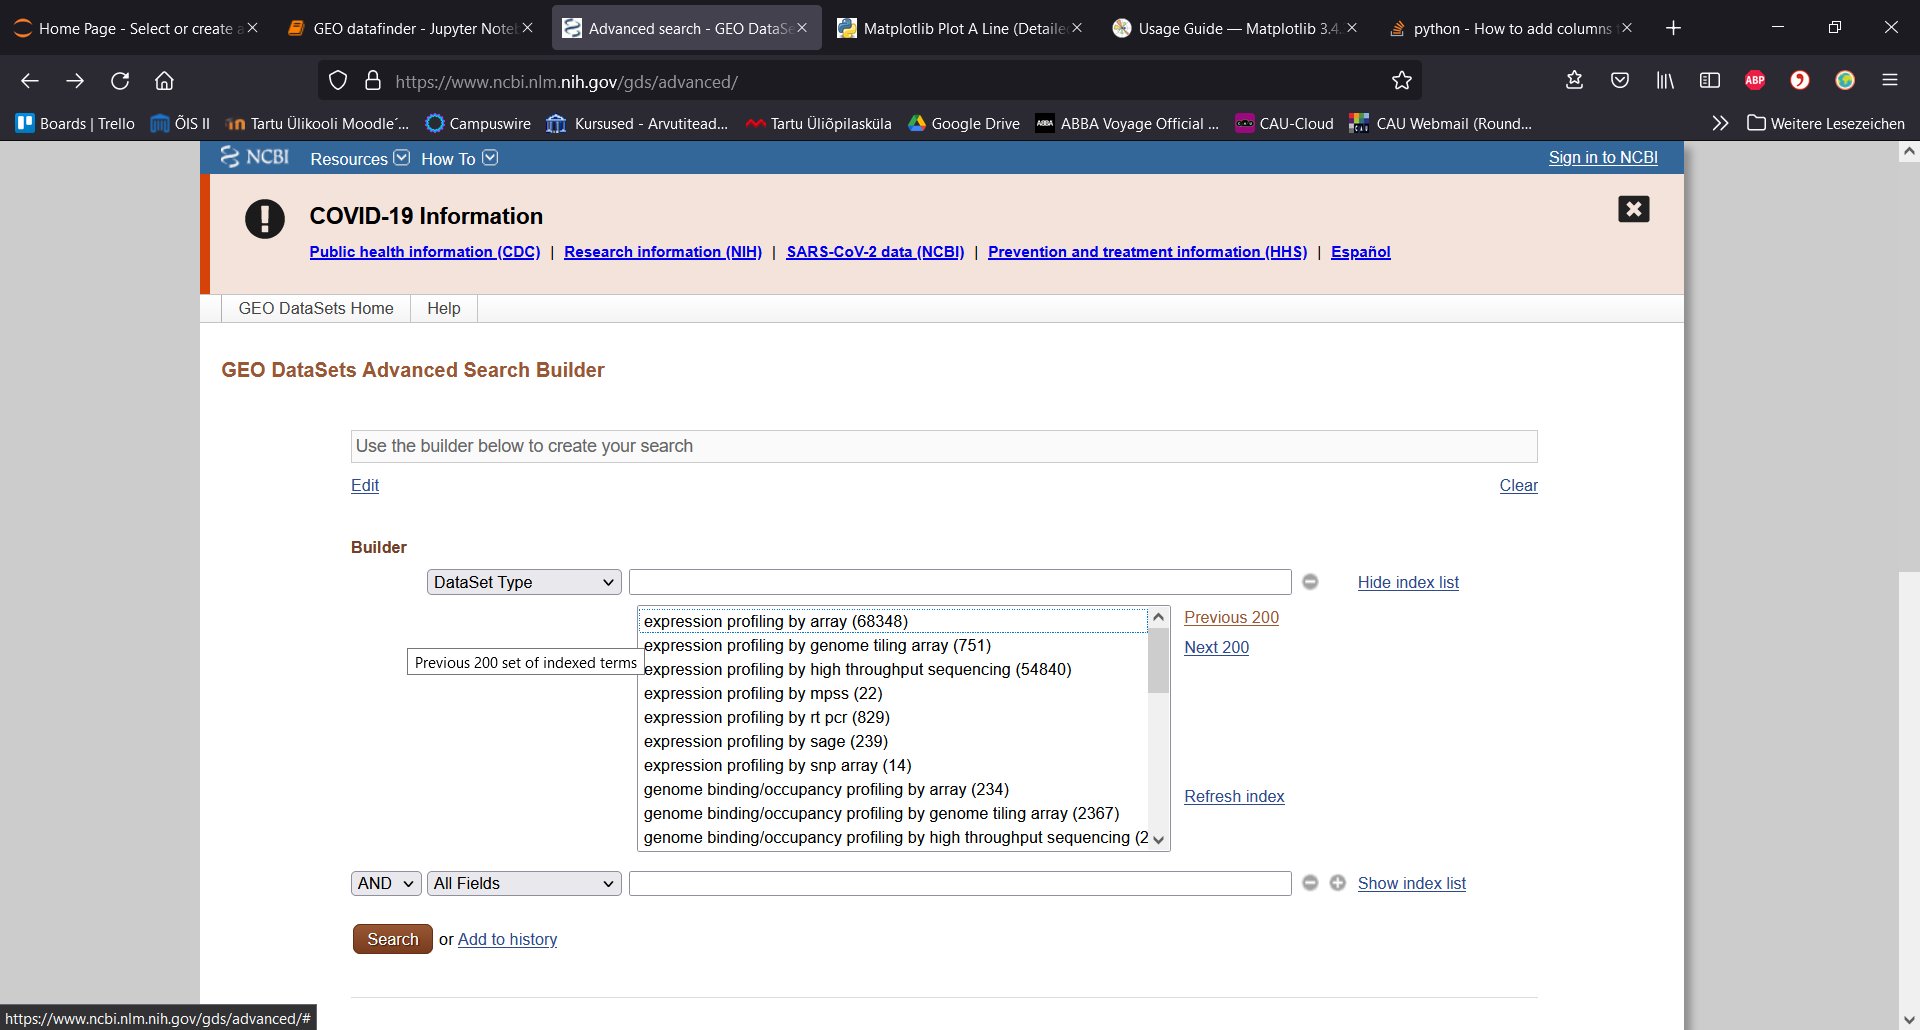


In [ ]:
Publication_Statistics = pd.read_csv('Publication_Statistics.csv', encoding='ISO-8859-1', index_col = 0)
a = np.sum(Publication_Statistics)
a

In [45]:
# import WormExp database to extract current GSE codes
columns = ["Categories","Gene_Set_name","Refs","Data_From","number","Rawdata","Additional"]
WormExp = pd.read_csv('WormExp_geo.csv', encoding='ISO-8859-1', skipinitialspace=True, usecols=columns)
gse_worm = list(set(WormExp["Rawdata"]))

# Creating loop to test out different queries, by changing publication year
#query = f"Caenorhabditis elegans [Organism] AND gse AND (Expression profiling by high throughput sequencing [DataSet Type] OR Expression profiling by array [DataSet Type]) AND {year[i]}:{year[i+1]}[Publication Date]"
   
year = np.arange(2005,2022,1)
#Publication_Statistics = pd.DataFrame(index=[year])

PublicationsExpressionBySNP= []
for i in range(0,17,1):
    Entrez.email = "jennifer.neumaier@ut.ee"
    query = f"Caenorhabditis elegans[Organism] AND Expression profiling by snp array [DataSet Type] AND {year[i]-1}:{year[i]}[Publication Date]"
    handle = Entrez.esearch(db='gds', term=query, retmax=5000, usehistory=True)
    result = Entrez.read(handle)
    handle.close()
    PublicationsExpressionBySNP.append(len(result["IdList"]))
Publication_Statistics["PublicationsExpressionBySNP"] = PublicationsExpressionBySNP

Publication_Statistics
#Publication_Statistics.to_csv("Publication_Statistics.csv")


,PublicationsCElegans,PublicationsExpressionByArray,PublicationsExpressionBySequencing,PublicationsExpressionByGenomeTiling,PublicationsExpressionByMPSS,PublicationsExpressionByRTPCR,PublicationsExpressionBySage,PublicationsExpressionBySNP
2005,449,23,0,0,0,0,1,0
2006,734,39,0,0,0,0,0,0
2007,610,44,0,1,0,0,0,0
2008,736,44,0,1,0,0,0,0
2009,1254,54,2,2,0,0,0,0
2010,2194,73,5,55,0,0,0,0
2011,2550,81,12,56,0,0,0,0
2012,2390,88,18,7,0,0,0,0
2013,3511,78,26,9,0,0,0,0
2014,3432,60,46,5,0,0,0,0


In [47]:
print(f"Publications about C elegans from 2005 to now: {PublicationsCElegans}")
print(f"Publications from 2005 to now for Expression profiling by array: {PublicationsExpressionByArray}")
print(f"Publications from 2005 to now for high-throughput sequencing: {PublicationsExpressionBySequencing}")
print(f"Publications from 2005 to now for Expression profiling by genome tiling array: {PublicationsExpressionByGenomeTiling}")
print(f"Publications from 2005 to now for Expression profiling by mpss: {PublicationsExpressionByMPSS}")
print(f"Publications from 2005 to now for Expression profiling by RT PCR: {PublicationsExpressionByRTPCR}")
print(f"Publications from 2005 to now for Expression profiling by sage: {PublicationsExpressionBySage}")
print(f"Publications from 2005 to now for Expression profiling by snp array: {PublicationsExpressionBySNP}")

Publications about C elegans from 2005 to now: [449, 734, 610, 736, 1254, 2194, 2550, 2390, 3511, 3432, 2269, 2791, 3603, 4109, 4644, 5000, 4819]
Publications from 2005 to now for Expression profiling by array: [23, 39, 44, 44, 54, 73, 81, 88, 78, 60, 50, 42, 54, 44, 28, 33, 21]
Publications from 2005 to now for high-throughput sequencing: [0, 0, 0, 0, 2, 5, 12, 18, 26, 46, 65, 90, 112, 141, 181, 214, 211]
Publications from 2005 to now for Expression profiling by genome tiling array: [0, 0, 1, 1, 2, 55, 56, 7, 9, 5, 2, 4, 3, 1, 0, 0, 0]
Publications from 2005 to now for Expression profiling by mpss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Publications from 2005 to now for Expression profiling by RT PCR: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Publications from 2005 to now for Expression profiling by sage: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Publications from 2005 to now for Expression profiling by snp array: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Text(0.5, 0, 'Year')

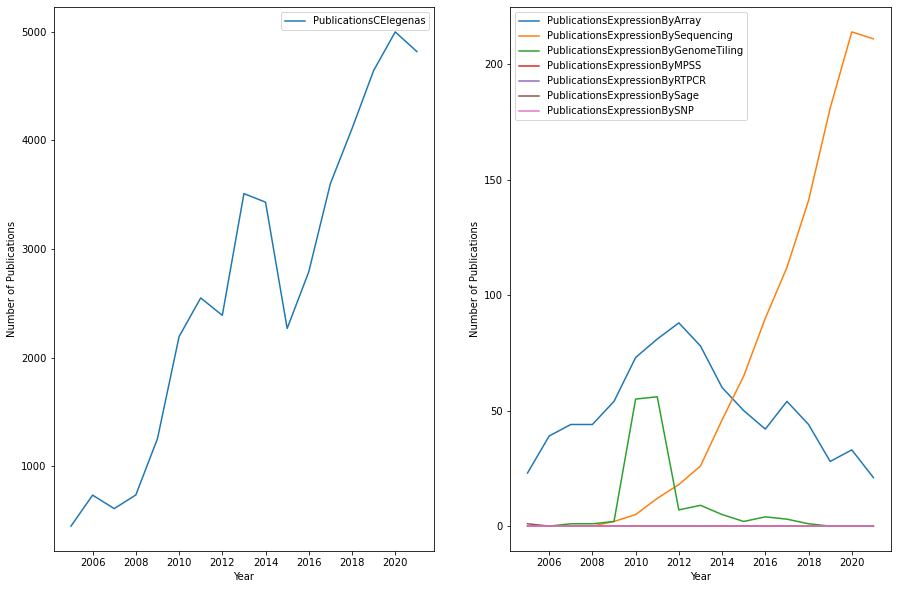

In [25]:
# Create graph to visualize results
year = np.arange(2005,2022,1)
Publication_Statistics = pd.read_csv('Publication_Statistics.csv', encoding='ISO-8859-1', index_col = 0)
Publication_Statistics

plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.plot(year,Publication_Statistics["PublicationsCElegans"], label = "PublicationsCElegenas")
plt.legend()
plt.ylabel("Number of Publications")
plt.xlabel("Year")

plt.subplot(1,2,2)
plt.plot(year, Publication_Statistics.drop(['PublicationsCElegans'], axis=1)) 
plt.legend(Publication_Statistics.drop(['PublicationsCElegans'], axis=1))
plt.ylabel("Number of Publications")
plt.xlabel("Year")

It can be seen that the number of C.elegans experiments is steadily increasing, together with expression profiling by high throughput. Additionally, publications with expression profiling by genome tiling and array can be found. Therefore, it will be tested in the next segment, if experiments with these profiling methods can be found. The following statistics suggest to me, that the following query is sufficient to gather all relevant publications starting from 2015, the last year of publication in the database:

query = "Caenorhabditis elegans [Organism] AND (Expression profiling by high throughput sequencing [DataSet Type] OR Expression profiling by array [DataSet Type]) AND 2015/01:2021/10/15[Publication Date]"

Highest GSE in database: GSE68709 (Public on May 12, 2015)


In [39]:
# find out if experiments by genome tiling array can be found in current database
Entrez.email = "jennifer.neumaier@ut.ee"
query = "Caenorhabditis elegans[Organism] AND Expression profiling by high throughput sequencing[DataSet Type] AND 2005:2021 [Publication Date]"
    
# Search, using history results if cached before
handle = Entrez.esearch(db='gds', term=query, retmax=5000, usehistory=True)
result = Entrez.read(handle)
handle.close()

# search for GSE numbers
uid_regex = re.compile('[1-9]+0+([1-9]+[0-9]*)')
exception_list = []
gse_bio = []
for uid in result["IdList"]:
    if re.search(uid_regex, uid):
        gse_bio.append('GSE' + uid_regex.match(uid).group(1))
    else:
        exception_list.append(uid)

# store in pandas dataframe
gse_bio = pd.DataFrame(gse_bio, columns = ["GSE_output"])

# Put Rawdata in an extra table so that pd.merge can use it
gse_worm = pd.DataFrame(list(set(WormExp["Rawdata"])), columns = ["GSE_output"])

# Use pd.merge to create a table that contains all GSEs but with indicators where they are found
# left_only = only in database
# right_only = only on ncbi
output = pd.merge(gse_worm, gse_bio, how='outer', indicator= True)

both = np.where(output == "both")[0]
left = np.where(output == "left_only")[0]
right = np.where(output == "right_only")[0]

Database_Statistics = pd.DataFrame(index=["Query","Database","Both"])
Database_Statistics["PublicationsExpressionBySequencing"] = [580,240,43]
Database_Statistics

print(f"Number of entries found only in query: {len(right)}")
print(f"Number of entries found only in database: {len(left)}")
print(f"Number of entries in both: {len(both)}") 

Number of entries found only in query: 580
Number of entries found only in database: 240
Number of entries in both: 43


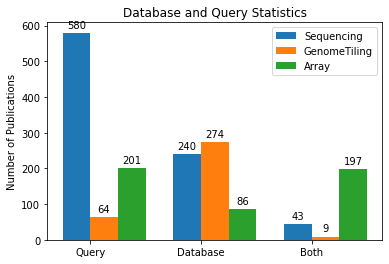

In [44]:
Database_Statistics = pd.read_csv('Database_Statistics.csv', encoding='ISO-8859-1', index_col = 0)
Database_Statistics

# Graph to display database statistics

labels = ["Query","Database","Both"]

x = np.arange(len(labels))  # the label locations
width = 0.25 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Database_Statistics["PublicationsExpressionBySequencing"], width, label='Sequencing')
rects2 = ax.bar(x + width/2, Database_Statistics["PublicationsExpressionByGenomeTiling"], width, label='GenomeTiling')
rects3 = ax.bar(x + 3*width/2, Database_Statistics["PublicationsExpressionByArray"], width, label='Array')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Publications')
ax.set_title('Database and Query Statistics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

#fig.tight_layout()

fig.savefig("Database_Statistics.png")

plt.show()

Plot the behaviour of the amount of data in database, query and both over all years

In [58]:
# Plotting number of GEO Datasets in Query, Database and Both over all years.
# Create three arrays. query = [], database = [], both = [], where for all years the number of publications found in database is saved.  
# Combine genome tiling array, Array and Sequencing

columns = ["Categories","Gene_Set_name","Refs","Data_From","number","Rawdata","Additional"]
WormExp = pd.read_csv('WormExp_geo.csv', encoding='ISO-8859-1', skipinitialspace=True, usecols=columns)
WormExp.head()

year = np.arange(2005,2022,1)


Publication_Database_Yearly = pd.DataFrame(index=[year])

query = []
database = []
both_ = []

for i in range(0,17,1):
    Entrez.email = "jennifer.neumaier@ut.ee"
    query_ = f"Caenorhabditis elegans[Organism] AND (Expression profiling by array [DataSet Type] OR Expression profiling by high throughout sequencing [DataSet Type] OR Expression profiling by genome tiling array [DataSet Type]) AND {year[i]-1}:{year[i]}[Publication Date]"
    handle = Entrez.esearch(db='gds', term=query_, retmax=5000, usehistory=True)
    result = Entrez.read(handle)
    handle.close()
    
    uid_regex = re.compile('[1-9]+0+([1-9]+[0-9]*)')
    exception_list = []
    gse_bio = []
    for uid in result["IdList"]:
        if re.search(uid_regex, uid):
            gse_bio.append('GSE' + uid_regex.match(uid).group(1))
        else:
            exception_list.append(uid)

    # store in pandas dataframe
    gse_bio = pd.DataFrame(gse_bio, columns = ["GSE_output"])

    # Put Rawdata in an extra table so that pd.merge can use it
    gse_worm = pd.DataFrame(list(set(WormExp["Rawdata"])), columns = ["GSE_output"])

    # merge
    output = pd.merge(gse_worm, gse_bio, how='outer', indicator= True)
    both = np.where(output == "both")[0]
    left = np.where(output == "left_only")[0]
    right = np.where(output == "right_only")[0]
            
    # Save merged outputs in array
    query.append(len(right))
    database.append(len(left))
    both_.append(len(both))
    
Publication_Database_Yearly["Query"] = query 
Publication_Database_Yearly["Database"] = database 
Publication_Database_Yearly["Both"] = both_ 

Publication_Database_Yearly
Publication_Database_Yearly.to_csv("Publication_Database_Yearly.csv")

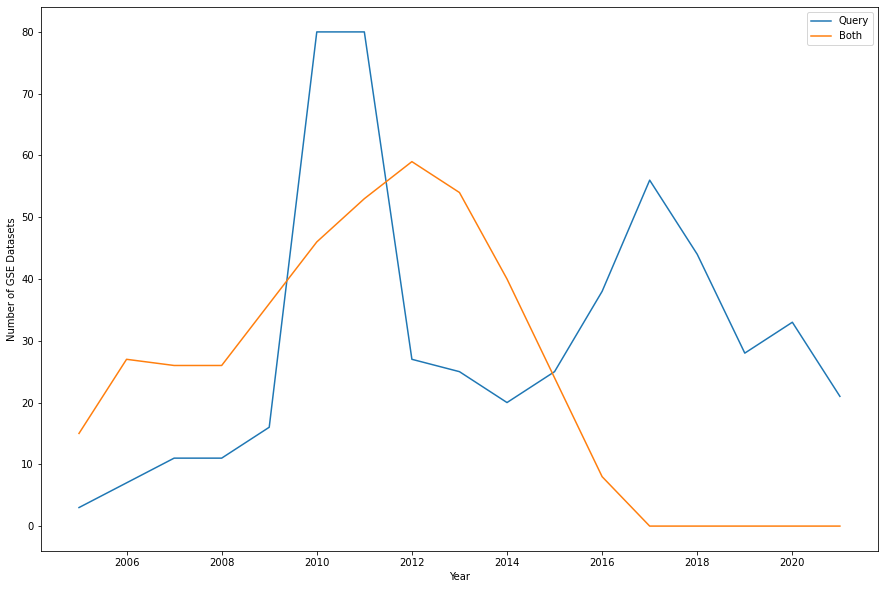

In [69]:
# Create graph to visualize results
year = np.arange(2005,2022,1)
Publication_Database_Yearly = pd.read_csv('Publication_Database_Yearly.csv', encoding='ISO-8859-1', index_col = 0)
Publication_Database_Yearly

plt.figure(figsize=(15,10))

plt.plot(year,Publication_Database_Yearly.drop(['Database'], axis=1))
plt.legend(Publication_Database_Yearly.drop(['Database'], axis=1))
plt.ylabel("Number of GSE Datasets")
plt.xlabel("Year")

plt.savefig("Publications_Yearls.png")
plt.show()

## Accessing GSM data 

In this section, the idea is to find rules to find out which data is useful and which is not, so that after categorisation, the data can be observed.
For datasets that were created by microarrays, the data can be find in the GSM samples in GEO. This technique however is not possible for high-throughput sequencing results. The data analysis is usually done in R via RPKM/FPKM or DESeq2 and the normalized counts uploaded as supplementary file to the GSE series. The command gse.download_supplementary_files() only works for supplementary files for every GSM, not for the GSE object. Therefore, in order to access supplmentary files in python directly, it will be tried to access the supplementary files directly through the FTP server. This way (hopefully) a script can be created that accesses the information for all hits in the created Excel file and stores them locally in respective folders. Afterwards, the script opens the Excel files and automatically finds up- and downregulated genes or tells me I have to do it manually. This last part will be created depending on the procedures I will encounter when learning the procedure.

### Expression profiling by array

In [8]:
# Importing .csv with information about GSE sets in database 

GSE_database = pd.read_csv("GSE_database_analysis.csv", encoding='ISO-8859-1', index_col = 0)
GSE_database


,title,geo_accession,status,submission_date,last_update_date,pubmed_id,summary,overall_design,type,contributor,...,platform_id,platform_taxid,sample_taxid,relation,contact_laboratory,contact_phone,contact_fax,contact_web_link,web_link,citation
0,['ChIPseq examination of EAP-1 binding across ...,['GSE52102'],['Public on Apr 08 2014'],['Nov 05 2013'],['May 15 2019'],['24685137'],['How epigenetic information is transmitted fr...,['EAP-1 binding ChIPseq libraries were prepare...,['Genome binding/occupancy profiling by high t...,"['Eric,L,Greer', 'Emily,,Brookes', 'Yun,,Zhu']",...,['GPL13657'],['6239'],['6239'],['BioProject: https://www.ncbi.nlm.nih.gov/bio...,NaN,NaN,NaN,NaN,NaN,NaN
1,['Members of the H3K4 trimethylation complex r...,['GSE30505'],['Public on Jul 08 2011'],['Jul 08 2011'],['Jul 06 2016'],['20555324'],['The plasticity of ageing suggests that longe...,['There are 23 samples in total. ASH-2 knock-d...,['Expression profiling by array'],"['Eric,L,Greer', 'Anne,,Brunet']",...,['GPL200'],['6239'],['6239'],['BioProject: https://www.ncbi.nlm.nih.gov/bio...,['Anne Brunet'],NaN,NaN,NaN,NaN,NaN
2,['Aging study'],['GSE12094'],['Public on Jul 29 2008'],['Jul 11 2008'],['Dec 27 2012'],['18662544'],['This SuperSeries is composed of the SubSerie...,['Refer to individual Series'],['Expression profiling by array'],NaN,...,"['GPL7065', 'GPL7066', 'GPL7067', 'GPL7068']",['6239'],['6239'],"['SuperSeries of: GSE12166', 'SuperSeries of: ...",NaN,['650-725-7671'],['650-725-7739'],NaN,NaN,NaN
3,['Linking toxicant physiological mode of actio...,['GSE21012'],['Public on Mar 23 2010'],['Mar 22 2010'],['Dec 27 2012'],['20331876'],['This SuperSeries is composed of the SubSerie...,['Refer to individual Series'],['Expression profiling by array'],NaN,...,['GPL10238'],['6239'],['6239'],"['SuperSeries of: GSE21008', 'SuperSeries of: ...",NaN,['02920874507'],NaN,['kille.cf.ac.uk'],NaN,NaN
4,['GLD-1 mRNA regulation'],['GSE33084'],['Public on Jun 18 2012'],['Oct 19 2011'],['Apr 30 2013'],['22693456'],['This SuperSeries is composed of the SubSerie...,['Refer to individual Series'],['Genome binding/occupancy profiling by genome...,"['Claudia,,Scheckel', 'Dimos,,Gaidatzis', 'Ste...",...,['GPL5634'],['6239'],['6239'],"['SuperSeries of: GSE33081', 'SuperSeries of: ...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,['Cell-specific microarray profiling of the C....,['GSE8004'],['Public on Jun 25 2007'],['Jun 04 2007'],['Jul 06 2016'],['17612406'],['Background: With its fully sequenced genome ...,['Our goal is to profile gene expression throu...,['Expression profiling by array'],"['Stephen,E,Von Stetina', 'Joseph,D,Watson', '...",...,['GPL200'],['6239'],['6239'],['BioProject: https://www.ncbi.nlm.nih.gov/bio...,NaN,['6153433447'],['6159365673'],['http://exploration.vanderbilt.edu/news/news_...,NaN,NaN
66,['Extension of lifespan in C. elegans by napht...,['GSE28301'],['Public on Mar 21 2012'],['Mar 31 2011'],['Jun 22 2020'],['21765926'],['Hormesis occurs when a low level stress elic...,"['Approximately 1,000 age-synchronized young a...",['Expression profiling by array'],"['Piper,R,Hunt', 'Tae,G,Son', 'Mark,A,Wilson',...",...,['GPL7727'],['6239'],['6239'],['BioProject: https://www.ncbi.nlm.nih.gov/bio...,['Computational Biology & Genomics Core'],NaN,NaN,NaN,NaN,NaN
67,['NGM versus CeMM growth'],['GSE6057'],['Public on Oct 18 2006'],['Oct 17 2006'],['Mar 16 2012'],['17023606'],['These three arrays are replicate extractions...,['Computed'],['Expression profiling by array'],"['Catharine,,Conley']",...,['GPL3411'],['6239'],['6239'],['BioProject: https://www.ncbi.nlm.nih.gov/bio...,NaN,['650-498-6012'],NaN,['http://genome-www5.stanford.edu/'],NaN,NaN
68,['Expression Profiling of MAP Kinase-Mediated ...,['GSE5069'],['Public on Aug 01 2006'],['Jun 12 2006'],['Sep 21 2012'],['17096596'],"['A unique allele of MAP kinase, mpk-1(ga111),...",['We analyzed six timepoints after MAP kinase ...,['Expression pro

In [26]:
# via GEOparse it is very easy to access data for gene expression profiling by array. 
# This script introduces some helpful commands to access the data directly in python.

geo_ID = "GSE11055"
gse = GEOparse.get_GEO(geo=geo_ID, destdir="./")

#gse.gpls["GPL200"].table
#gse.gpls["GPL200"].metadata   
#gse.gpls['GPL200'].columns

gene_symbols = gse.gpls["GPL200"].table[["ID", "Gene Title", "Gene Symbol"]]
gene_symbols = gene_symbols.rename(columns={"ID":"ID_REF"})
gene_symbols = gene_symbols.set_index('ID_REF')

pivoted_control_samples = gse.pivot_samples('VALUE')

# merging
full_table = pd.concat([pivoted_control_samples, gene_symbols], axis=1)
full_table

temp_cols=full_table.columns.tolist()
new_cols=temp_cols[-2:] + temp_cols[:-2]
full_table=full_table[new_cols]
full_table

# Script to download supplementary files and/or SRA files (raw data)

# downloading SRA files
# download_SRA(email, directory='series', filterby=None, nproc=1, **kwargs)
#gse.download_SRA

# download supplementary files
# download_supplementary_files(directory='series', download_sra=True, email=None, sra_kwargs=None, nproc=1)
#gse.download_supplementary_files(directory = "./supplementary_files/GSE11055", download_sra = False)

# GDS dataset -> curated dataset (genes have been identified)
# GEO2R operates on Series Matrix files which contain data extracted directly from the VALUE column of Sample tables. 
# Submitters are asked to supply normalized data in the VALUE column, rendering the Samples cross-comparable. 
# The majority of GEO data do conform to this rule. 
# GEO applies no further processing other than to perform a log2 transformation on values determined not to be in log space (see Options section)
#geo_ID = "GDS5195"
#gds = GEOparse.get_GEO(geo=geo_ID, destdir="./")

#gds.table

03-Nov-2021 18:11:48 DEBUG utils - Directory ./ already exists. Skipping.
03-Nov-2021 18:11:48 INFO GEOparse - File already exist: using local version.
03-Nov-2021 18:11:48 INFO GEOparse - Parsing ./GSE11055_family.soft.gz: 
03-Nov-2021 18:11:48 DEBUG GEOparse - DATABASE: GeoMiame
03-Nov-2021 18:11:48 DEBUG GEOparse - SERIES: GSE11055
03-Nov-2021 18:11:48 DEBUG GEOparse - PLATFORM: GPL200
03-Nov-2021 18:11:49 DEBUG GEOparse - SAMPLE: GSM279203
03-Nov-2021 18:11:49 DEBUG GEOparse - SAMPLE: GSM279204
03-Nov-2021 18:11:49 DEBUG GEOparse - SAMPLE: GSM279205
03-Nov-2021 18:11:50 DEBUG GEOparse - SAMPLE: GSM279206
03-Nov-2021 18:11:50 DEBUG GEOparse - SAMPLE: GSM279207
03-Nov-2021 18:11:50 DEBUG GEOparse - SAMPLE: GSM279208
03-Nov-2021 18:11:50 DEBUG GEOparse - SAMPLE: GSM279209
03-Nov-2021 18:11:51 DEBUG GEOparse - SAMPLE: GSM279210
03-Nov-2021 18:11:51 DEBUG GEOparse - SAMPLE: GSM279211
03-Nov-2021 18:11:51 DEBUG GEOparse - SAMPLE: GSM279212
03-Nov-2021 18:11:51 DEBUG GEOparse - SAMPLE: GS

,Gene Title,Gene Symbol,GSM279203,GSM279204,GSM279205,GSM279206,GSM279207,GSM279208,GSM279209,GSM279210,GSM279211,GSM279212,GSM279213,GSM279214,GSM279215,GSM279216,GSM279217,GSM279218,GSM279219,GSM279220
ID_REF,,,,,,,,,,,,,,,,,,,,
171720_x_at,Protein SNX-14,snx-14,165,159,176,171,175,182,184,179,156,164,159,163,173,178,181,183,143,195
171721_x_at,Protein T01G9.2,T01G9.2,367,424,450,491,401,359,356,352,365,267,248,210,210,255,183,490,186,353
171722_x_at,Protein F56B3.11,F56B3.11,307,434,493,575,619,543,525,460,347,415,571,646,597,663,589,566,673,550
171723_x_at,Protein VIT-4 /// locus:vit-4,vit-4 /// WBGene00006928,17,21,19,16,13,15,14,12,19,20,16,25,13,18,15,19,17,16
171724_x_at,Protein CDC-25.1 /// locus:cdc-25.1,cdc-25.1 /// WBGene00000386,115,92,83,76,90,86,95,92,120,97,81,76,59,62,92,78,119,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AFFX-r2-YEL002c/WBP1-3_at,NaN,NaN,5,6,8,11,8,9,6,8,5,5,9,8,5,6,9,8,9,8
AFFX-r2-YEL002c/WBP1-5_at,NaN,NaN,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
AFFX-r2-YEL018w/-3_at,NaN,NaN,5,5,5,5,5,5,6,5,5,5,6,5,5,5,5,5,5,5


### Expression profiling by high-throughput sequencing

In [23]:
# https://techexpert.tips/python/python-download-file-ftp-server/

GSE_ftp = pd.read_csv("test_file_ftp.csv", encoding='ISO-8859-1', index_col = 0)
GSE_ftp

GSE_ftp["supplementary_file"][5]

"['ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE145nnn/GSE145123/suppl/GSE145123_DEseq_analysis_N2_AGD1289.xlsx']"

In [26]:
import wget
import gzip
import shutil

link = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE145nnn/GSE145123/suppl/GSE145123_DEseq_analysis_N2_AGD1289.xlsx"

#mkdir script
#out_dir = "D:\Bioinformatics\Projects\WormExp\datafinder\supplementary_files"
wget.download(link, out = "D:\Bioinformatics\Projects\WormExp\datafinder\supplementary_files")

# write script that tests if the downloaded data is gzipped -> use gzip to open and then use pandas
# or simple xlsx -> open directly with respective pandas function
# or text -> open directly with respective pandas function
with gzip.open("D:\Bioinformatics\Projects\WormExp\datafinder\supplementary_files\GSE145123_DEseq_analysis_N2_AGD1289.xlsx.gz", "rb") as f:
    features_train = pd.read_csv(f, sep = "\t")

features_train.head()
    

100% [..........................................................................] 3519280 / 3519280

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Bioinformatics\\Projects\\WormExp\\datafinder\\supplementary_files\\GSE145123_DEseq_analysis_N2_AGD1289.xlsx.gz'

## Sources/Ideas

https://newarkcaptain.com/how-to-retrieve-ncbi-geo-information-using-apis-part1/
https://newarkcaptain.com/how-to-retrieve-ncbi-geo-information-using-apis-part2/

geoES.py: https://github.com/hariesramdhani/winter-internship-2017/tree/master/src
